In [31]:
"""
Web scraping price information from www.mediamarkt.es
Based on:
https://github.com/Brinkhuis/Mediamarkt/blob/master/code/mediamarkt.py
"""

import ast
import requests
import urllib

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import time
import datetime

from bs4 import BeautifulSoup
from tqdm import tqdm
from requests.exceptions import HTTPError

%matplotlib inline

In [32]:
# URL dónde está la lista de productos
URL = "https://www.mediamarkt.es/sitemap/sitemap-productlist.xml"

In [33]:
# Configuramos el user agent

headers = requests.utils.default_headers()
print(headers)

{'User-Agent': 'python-requests/2.21.0', 'Accept-Encoding': 'gzip, deflate', 'Accept': '*/*', 'Connection': 'keep-alive'}


In [34]:
# Common user agent list
# Referencia: http://www.networkinghowtos.com/howto/common-user-agent-list/
# Google Chrome
# "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/58.0.3029.110 Safari/537.36"
# Mozilla Firefox
# "Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:53.0) Gecko/20100101 Firefox/53.0"
# Microsoft Edge
# Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/51.0.2704.79 
# Safari/537.36 Edge/14.14393
# Google bot
# Mozilla/5.0 (compatible; Googlebot/2.1; +http://www.google.com/bot.html)
# Bing bot
# Mozilla/5.0 (compatible; bingbot/2.0; +http://www.bing.com/bingbot.htm)


In [35]:
# Actualizamos el user agent
headers.update({'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:53.0) Gecko/20100101 Firefox/53.0'})
print(headers)

{'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:53.0) Gecko/20100101 Firefox/53.0', 'Accept-Encoding': 'gzip, deflate', 'Accept': '*/*', 'Connection': 'keep-alive'}


In [36]:
# Definimoos la función para leer el xml y extraer los links que pasaremos
# Referencia:
# https://stackoverflow.com/questions/18966368/python-beautifulsoup-scrape-tables
# Le paso la URL como parámetro, así podrá valer para los diferentes sitios.
def get_products (URL):
    soup = BeautifulSoup(requests.get(URL).text, 'lxml')
    #links = soup.find_all('loc')
    links = []
    #links = soup.find_all("loc")
    for link in soup.find_all("loc"):
        links.append(str(link).replace("<loc>","").replace("</loc>",""))
    return links

In [37]:
# Cargamos los links a partir del sitemap
pagelinks = get_products(URL)

In [38]:
# Mostramos los primeros 10
pagelinks[1:10]

['https://www.mediamarkt.es/es/category/_afeitado-y-depilaci%C3%B3n-701138.html',
 'https://www.mediamarkt.es/es/category/_afeitadoras-faciales-701281.html',
 'https://www.mediamarkt.es/es/category/_afeitadoras-corporales-701282.html',
 'https://www.mediamarkt.es/es/category/_afeitadoras-multifunci%C3%B3n-701283.html',
 'https://www.mediamarkt.es/es/category/_cortapelos-701284.html',
 'https://www.mediamarkt.es/es/category/_barberos-701285.html',
 'https://www.mediamarkt.es/es/category/_depiladoras-ipl-701286.html',
 'https://www.mediamarkt.es/es/category/_rasuradoras-701287.html',
 'https://www.mediamarkt.es/es/category/_depiladoras-de-arranque-701288.html']

In [39]:
#Comprobamos la cantidad de pagelinks
len(pagelinks)

1016

In [40]:
# Referencia del código:
# https://github.com/Brinkhuis/Mediamarkt/blob/master/code/mediamarkt.py
def npages(mysoup):
    pagination = list()
    npages = 1
    for page_number in mysoup.find_all('div', {'class': 'pagination-wrapper cf'}):
        pagination.append(page_number.find_all('a'))
        npages = int(str(pagination[0]).split(', ')[-2].strip('</a>').split('>')[-1])
        # Para debug, se imprime el número de páginas.
        print ("Número de páginas: %d" % npages)
    return npages 

In [41]:
# Referencia del código:
# https://github.com/Brinkhuis/Mediamarkt/blob/master/code/mediamarkt.py      


def get_data(URL, output_file = None):
    # Para debug, se imprime la URL que se está escaneando
    print("Rastreando: %s" % URL)
    item_list = list()    
    # Handle the requests exceptions
    # Referencia:
    # https://realpython.com/python-requests/
    try:
        response = requests.get(URL)
        # If the response was successful, no Exception will be raised
        response.raise_for_status()
    except HTTPError as http_err:
        print(f'HTTP error occurred: {http_err}')  # Python 3.6
    except Exception as err:
        print(f'Other error occurred: {err}')  # Python 3.6
    else:
        for page in tqdm(range(1, npages(BeautifulSoup(response.text, 'html.parser')) +1)):
            try:
                pageresponse = requests.get(URL + '?page=' + str(page))
                # If the response was successful, no Exception will be raised
                response.raise_for_status()
            except HTTPError as http_err:
                print(f'HTTP error occurred: {http_err}')  # Python 3.6
            except Exception as err:
                print(f'Other error occurred: {err}')  # Python 3.6
            else:
                soup = BeautifulSoup(pageresponse.text, 'html.parser')
                all_scripts = soup.find_all('script')
                for script in all_scripts:
                    if script.text.startswith('var product'):
                        item_list.append(ast.literal_eval(script.text.split(' = ')[1].strip(';')))
    
    productinfo = pd.DataFrame() 
    if (len(item_list)>0):
        productinfo = pd.DataFrame(item_list)
        productinfo['price'] = pd.to_numeric(productinfo['price'], errors='coerce')
        
  
    #productinfo.to_csv(output_file, index=False)    
    #print(f'{productinfo.shape[0]} records saved to {output_file}')
    
    return productinfo

In [42]:
def viz_data(input_file, output_file, query = ':', x_px = 1500, y_px = 1000, d_pi = 150):
    productinfo = pd.read_csv(input_file)
    
    productinfo = productinfo[query]

    #x_pixels, y_pixels, dpi = 1500, 1000, 150
    x_pixels, y_pixels, dpi = x_px, y_px, d_pi
    x_inch, y_inch = x_pixels / dpi, y_pixels / dpi

    plt.figure(figsize=(x_inch, y_inch), dpi=dpi)
    sns.boxplot(x='price',
                y='brand',
                data=productinfo.groupby('brand').filter(lambda x: len(x) > 3),
                order=list(productinfo.groupby('brand').filter(lambda x: len(x) > 3)
                           .groupby('brand').price.median().sort_values(ascending=False).index),
                palette='PRGn',
                width=0.75).set_title('Price Distribution per Brand')
    sns.despine(offset=10, trim=True)
    plt.savefig(output_file)
    plt.show()
    plt.close()
    
    print(f'Visualization saved to {output_file}')


In [43]:
#def main():
dat = './data/productinfo.csv'
viz = './plots/price_distribution_brand.png'

# Limito a los 10 primeras líneas
products = pd.DataFrame()
total_products = pd.DataFrame()
k=0
#for link in pagelinks[1:10]:
for link in pagelinks:
    k += 1
    #print("Escaneando pagina %d de %d" % (k, len(pagelinks[1:10])))
    print("Escaneando página %d de %d" % (k, len(pagelinks)))
    products = get_data(link, dat)
    time.sleep(2)
    total_products = total_products.append(products)
        
print("Done. The prices have been scrapped.")


Escaneando página 1 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_belleza-y-salud-701113.html


100%|██████████| 1/1 [00:00<00:00,  1.63it/s]


Escaneando página 2 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_afeitado-y-depilaci%C3%B3n-701138.html


100%|██████████| 1/1 [00:01<00:00,  1.23s/it]


Escaneando página 3 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_afeitadoras-faciales-701281.html
Número de páginas: 3


100%|██████████| 3/3 [00:02<00:00,  1.17it/s]


Escaneando página 4 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_afeitadoras-corporales-701282.html


100%|██████████| 1/1 [00:00<00:00,  1.05it/s]


Escaneando página 5 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_afeitadoras-multifunci%C3%B3n-701283.html
Número de páginas: 3


100%|██████████| 3/3 [00:03<00:00,  1.09s/it]


Escaneando página 6 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_cortapelos-701284.html
Número de páginas: 5


100%|██████████| 5/5 [00:04<00:00,  1.26it/s]


Escaneando página 7 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_barberos-701285.html
Número de páginas: 3


100%|██████████| 3/3 [00:02<00:00,  1.05it/s]


Escaneando página 8 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_depiladoras-ipl-701286.html
Número de páginas: 2


100%|██████████| 2/2 [00:02<00:00,  1.15s/it]


Escaneando página 9 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_rasuradoras-701287.html


100%|██████████| 1/1 [00:00<00:00,  1.05it/s]


Escaneando página 10 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_depiladoras-de-arranque-701288.html
Número de páginas: 3


100%|██████████| 3/3 [00:03<00:00,  1.19s/it]


Escaneando página 11 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_recambios-y-accesorios-701289.html
Número de páginas: 2


100%|██████████| 2/2 [00:02<00:00,  1.19s/it]


Escaneando página 12 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_cuidado-del-cabello-701139.html


100%|██████████| 1/1 [00:00<00:00,  1.67it/s]


Escaneando página 13 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_secadores-de-pelo-701290.html
Número de páginas: 5


100%|██████████| 5/5 [00:04<00:00,  1.14it/s]


Escaneando página 14 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_planchas-de-pelo-701291.html
Número de páginas: 5


100%|██████████| 5/5 [00:06<00:00,  1.12s/it]


Escaneando página 15 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_moldeadores-de-pelo-701292.html
Número de páginas: 4


100%|██████████| 4/4 [00:05<00:00,  1.31s/it]


Escaneando página 16 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_cepillos-de-calor-701293.html
Número de páginas: 2


100%|██████████| 2/2 [00:01<00:00,  1.03it/s]


Escaneando página 17 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_rizadores-701294.html


100%|██████████| 1/1 [00:00<00:00,  1.58it/s]


Escaneando página 18 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_cuidado-dental-701140.html


100%|██████████| 1/1 [00:00<00:00,  1.73it/s]


Escaneando página 19 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_cepillos-de-dientes-701295.html
Número de páginas: 5


100%|██████████| 5/5 [00:04<00:00,  1.29it/s]


Escaneando página 20 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_cepillos-infantiles-701296.html


100%|██████████| 1/1 [00:01<00:00,  1.01s/it]


Escaneando página 21 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_irrigadores-701297.html


100%|██████████| 1/1 [00:00<00:00,  1.55it/s]


Escaneando página 22 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_recambios-cuidado-dental-701298.html
Número de páginas: 2


100%|██████████| 2/2 [00:01<00:00,  1.26it/s]


Escaneando página 23 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_cuidado-facial-701141.html
Número de páginas: 4


100%|██████████| 4/4 [00:03<00:00,  1.15it/s]


Escaneando página 24 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_m%C3%A1quinas-de-sauna-facial-701299.html


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Escaneando página 25 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_cepillos-y-limpiadores-faciales-701300.html
Número de páginas: 2


100%|██████████| 2/2 [00:01<00:00,  1.04it/s]


Escaneando página 26 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_rejuvenecedores-tonificadores-701301.html


100%|██████████| 1/1 [00:00<00:00,  1.32it/s]


Escaneando página 27 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_espejos-701302.html


100%|██████████| 1/1 [00:00<00:00,  1.86it/s]


Escaneando página 28 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_cuidado-corporal-701142.html
Número de páginas: 5


100%|██████████| 5/5 [00:04<00:00,  1.18it/s]


Escaneando página 29 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_cavitaci%C3%B3n-y-radiofrecuencia-701303.html


100%|██████████| 1/1 [00:00<00:00,  1.20it/s]


Escaneando página 30 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_masajeadores-y-anticelul%C3%ADticos-701304.html
Número de páginas: 2


100%|██████████| 2/2 [00:01<00:00,  1.16it/s]


Escaneando página 31 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_cremas-y-tratamientos-corporales-701305.html


100%|██████████| 1/1 [00:00<00:00,  1.08it/s]


Escaneando página 32 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_packs-de-cuidado-corporal-701306.html


100%|██████████| 1/1 [00:00<00:00,  1.95it/s]


Escaneando página 33 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_juguetes-sexuales-701307.html
Número de páginas: 3


100%|██████████| 3/3 [00:03<00:00,  1.00it/s]


Escaneando página 34 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_cuidado-de-pies-y-manos-701143.html
Número de páginas: 3


100%|██████████| 3/3 [00:03<00:00,  1.09s/it]


Escaneando página 35 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_manicura-y-pedicura-701308.html


100%|██████████| 1/1 [00:01<00:00,  1.27s/it]


Escaneando página 36 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_secadores-y-l%C3%A1mparas-uv-led-701309.html


100%|██████████| 1/1 [00:00<00:00,  1.81it/s]


Escaneando página 37 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_kit-de-manicura-701310.html


100%|██████████| 1/1 [00:00<00:00,  1.70it/s]


Escaneando página 38 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_sets-y-accesorios-701311.html


100%|██████████| 1/1 [00:00<00:00,  1.30it/s]


Escaneando página 39 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_hidromasaje-y-parafina-701312.html


100%|██████████| 1/1 [00:00<00:00,  1.78it/s]


Escaneando página 40 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_limadores-de-durezas-701313.html


100%|██████████| 1/1 [00:00<00:00,  1.52it/s]


Escaneando página 41 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_salud-y-bienestar-701144.html


100%|██████████| 1/1 [00:00<00:00,  1.89it/s]


Escaneando página 42 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_b%C3%A1sculas-de-ba%C3%B1o-701314.html
Número de páginas: 4


100%|██████████| 4/4 [00:04<00:00,  1.01it/s]


Escaneando página 43 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_almohadillas-el%C3%A9ctricas-701315.html
Número de páginas: 4


100%|██████████| 4/4 [00:04<00:00,  1.01it/s]


Escaneando página 44 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_m%C3%A1quinas-fitness-701316.html


100%|██████████| 1/1 [00:00<00:00,  1.44it/s]


Escaneando página 45 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_mantas-el%C3%A9ctricas-701317.html


100%|██████████| 1/1 [00:00<00:00,  1.67it/s]


Escaneando página 46 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_aparatos-m%C3%A9dicos-701318.html
Número de páginas: 3


100%|██████████| 3/3 [00:04<00:00,  1.69s/it]


Escaneando página 47 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_tensi%C3%B3metros-702262.html
Número de páginas: 2


100%|██████████| 2/2 [00:01<00:00,  1.07it/s]


Escaneando página 48 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_cardi%C3%B3metros-702263.html


100%|██████████| 1/1 [00:00<00:00,  1.53it/s]


Escaneando página 49 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_term%C3%B3metros-702264.html


100%|██████████| 1/1 [00:01<00:00,  1.12s/it]


Escaneando página 50 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_pulsiox%C3%ADmetros-702265.html


100%|██████████| 1/1 [00:00<00:00,  1.44it/s]


Escaneando página 51 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_masaje-701319.html
Número de páginas: 3


100%|██████████| 3/3 [00:03<00:00,  1.09s/it]


Escaneando página 52 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_l%C3%A1mparas-de-infrarrojos-701320.html


100%|██████████| 1/1 [00:00<00:00,  1.43it/s]


Escaneando página 53 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_humidificadores-701321.html
Número de páginas: 2


100%|██████████| 2/2 [00:01<00:00,  1.44it/s]


Escaneando página 54 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_deshumificadores-701322.html


100%|██████████| 1/1 [00:00<00:00,  1.58it/s]


Escaneando página 55 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_purificadores-de-aire-701323.html


100%|██████████| 1/1 [00:00<00:00,  1.16it/s]


Escaneando página 56 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_cuidado-del-beb%C3%A9-701145.html
Número de páginas: 3


100%|██████████| 3/3 [00:02<00:00,  1.36it/s]


Escaneando página 57 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_vigilabeb%C3%A9s-701325.html


100%|██████████| 1/1 [00:00<00:00,  1.77it/s]


Escaneando página 58 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_b%C3%A1sculas-701326.html


100%|██████████| 1/1 [00:00<00:00,  1.73it/s]


Escaneando página 59 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_term%C3%B3metros-para-beb%C3%A9-701328.html


100%|██████████| 1/1 [00:00<00:00,  1.65it/s]


Escaneando página 60 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_humidificadores-701329.html


100%|██████████| 1/1 [00:01<00:00,  1.08s/it]


Escaneando página 61 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_preparaci%C3%B3n-alimentos-para-beb%C3%A9-701330.html


100%|██████████| 1/1 [00:00<00:00,  1.07it/s]


Escaneando página 62 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_campa%C3%B1as-y-ofertas-701114.html


100%|██████████| 1/1 [00:00<00:00,  1.60it/s]


Escaneando página 63 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_oportunidades-701125.html
Número de páginas: 30


100%|██████████| 30/30 [00:29<00:00,  1.12it/s]


Escaneando página 64 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_deporte-y-foto-712514.html


100%|██████████| 1/1 [00:00<00:00,  1.57it/s]


Escaneando página 65 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_electrodom%C3%A9sticos-712515.html
Número de páginas: 12


100%|██████████| 12/12 [00:12<00:00,  1.16it/s]


Escaneando página 66 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_entretenimiento-712516.html
Número de páginas: 10


100%|██████████| 10/10 [00:12<00:00,  1.27s/it]


Escaneando página 67 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_inform%C3%A1tica-712517.html
Número de páginas: 2


100%|██████████| 2/2 [00:01<00:00,  1.39it/s]


Escaneando página 68 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_telefon%C3%ADa-712518.html
Número de páginas: 4


100%|██████████| 4/4 [00:04<00:00,  1.09s/it]


Escaneando página 69 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_tv-y-audio-712519.html
Número de páginas: 4


100%|██████████| 4/4 [00:03<00:00,  1.18it/s]


Escaneando página 70 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_plan-renove-721079.html
Número de páginas: 62


100%|██████████| 62/62 [01:04<00:00,  1.02it/s]


Escaneando página 71 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_tv-y-audio-721097.html
Número de páginas: 19


100%|██████████| 19/19 [00:17<00:00,  1.12it/s]


Escaneando página 72 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_tv-4k-hasta-43-721105.html


100%|██████████| 1/1 [00:00<00:00,  1.60it/s]


Escaneando página 73 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_tv-4k-de-44-a-55-721101.html
Número de páginas: 4


100%|██████████| 4/4 [00:03<00:00,  1.30it/s]


Escaneando página 74 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_tv-4k-de-56-a-65-721104.html
Número de páginas: 3


100%|██████████| 3/3 [00:02<00:00,  1.10it/s]


Escaneando página 75 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_tv-4k-a-partir-de-66-721100.html


100%|██████████| 1/1 [00:01<00:00,  1.04s/it]


Escaneando página 76 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_barras-de-sonido-721103.html
Número de páginas: 2


100%|██████████| 2/2 [00:01<00:00,  1.00it/s]


Escaneando página 77 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_altavoces-721102.html
Número de páginas: 8


100%|██████████| 8/8 [00:10<00:00,  1.40s/it]


Escaneando página 78 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_inform%C3%A1tica-721095.html
Número de páginas: 22


100%|██████████| 22/22 [00:33<00:00,  1.06it/s]


Escaneando página 79 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_impresoras-721108.html
Número de páginas: 8


100%|██████████| 8/8 [00:07<00:00,  1.09it/s]


Escaneando página 80 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_pcs-721109.html
Número de páginas: 3


100%|██████████| 3/3 [00:02<00:00,  1.10it/s]


Escaneando página 81 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_port%C3%A1tiles-721110.html
Número de páginas: 11


100%|██████████| 11/11 [00:11<00:00,  1.03it/s]


Escaneando página 82 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_tablets-721111.html


100%|██████████| 1/1 [00:01<00:00,  1.11s/it]


Escaneando página 83 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_accesorios-723518.html


100%|██████████| 1/1 [00:00<00:00,  1.38it/s]


Escaneando página 84 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_telefon%C3%ADa-721096.html
Número de páginas: 9


100%|██████████| 9/9 [00:11<00:00,  1.32s/it]


Escaneando página 85 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_smartphones-721106.html
Número de páginas: 6


100%|██████████| 6/6 [00:06<00:00,  1.03s/it]


Escaneando página 86 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_smartwatches-721107.html
Número de páginas: 4


100%|██████████| 4/4 [00:02<00:00,  1.39it/s]


Escaneando página 87 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_accesorios-723517.html


100%|██████████| 1/1 [00:01<00:00,  1.11s/it]


Escaneando página 88 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_deporte-y-foto-721092.html
Número de páginas: 12


100%|██████████| 12/12 [00:16<00:00,  1.42s/it]


Escaneando página 89 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_fotograf%C3%ADa-721112.html
Número de páginas: 10


100%|██████████| 10/10 [00:13<00:00,  1.26s/it]


Escaneando página 90 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_movilidad-721113.html
Número de páginas: 3


100%|██████████| 3/3 [00:03<00:00,  1.20s/it]


Escaneando página 91 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_entretenimiento-721094.html


100%|██████████| 1/1 [00:00<00:00,  1.15it/s]


Escaneando página 92 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_tv-audio-y-foto-701116.html


100%|██████████| 1/1 [00:00<00:00,  1.24it/s]


Escaneando página 93 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_televisi%C3%B3n-701130.html


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Escaneando página 94 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_televisores-701210.html
Número de páginas: 12


100%|██████████| 12/12 [00:12<00:00,  1.04it/s]


Escaneando página 95 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_tv-hasta-27-pulgadas-702040.html
Número de páginas: 2


100%|██████████| 2/2 [00:01<00:00,  1.10it/s]


Escaneando página 96 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_tv-28-32-pulgadas-702041.html
Número de páginas: 2


100%|██████████| 2/2 [00:01<00:00,  1.09it/s]


Escaneando página 97 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_tv-40-43-pulgadas-702042.html
Número de páginas: 2


100%|██████████| 2/2 [00:01<00:00,  1.17it/s]


Escaneando página 98 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_tv-48-50-pulgadas-702043.html
Número de páginas: 2


100%|██████████| 2/2 [00:01<00:00,  1.15it/s]


Escaneando página 99 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_tv-55-60-pulgadas-702044.html
Número de páginas: 3


100%|██████████| 3/3 [00:03<00:00,  1.09s/it]


Escaneando página 100 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_tv-desde-65-pulgadas-702045.html
Número de páginas: 4


100%|██████████| 4/4 [00:03<00:00,  1.02it/s]


Escaneando página 101 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_soportes-tv-701211.html
Número de páginas: 10


100%|██████████| 10/10 [00:13<00:00,  1.10s/it]


Escaneando página 102 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_tv-fijos-702046.html
Número de páginas: 2


100%|██████████| 2/2 [00:02<00:00,  1.06s/it]


Escaneando página 103 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_tv-inclinable-702047.html
Número de páginas: 2


100%|██████████| 2/2 [00:02<00:00,  1.15s/it]


Escaneando página 104 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_tv-con-brazo-702048.html
Número de páginas: 4


100%|██████████| 4/4 [00:05<00:00,  1.38s/it]


Escaneando página 105 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_tv-techo-702049.html


100%|██████████| 1/1 [00:01<00:00,  1.10s/it]


Escaneando página 106 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_soportes-proyector-702050.html


100%|██████████| 1/1 [00:01<00:00,  1.29s/it]


Escaneando página 107 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_soportes-altavoces-702051.html


100%|██████████| 1/1 [00:01<00:00,  1.36s/it]


Escaneando página 108 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_otros-soportes-702052.html


100%|██████████| 1/1 [00:01<00:00,  1.79s/it]


Escaneando página 109 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_internet-tv-tdt-sat%C3%A9lite-701212.html
Número de páginas: 3


100%|██████████| 3/3 [00:02<00:00,  1.12it/s]


Escaneando página 110 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_smart-tv-box-702053.html


100%|██████████| 1/1 [00:01<00:00,  1.10s/it]


Escaneando página 111 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_receptor-tdt-702054.html


100%|██████████| 1/1 [00:01<00:00,  1.73s/it]


Escaneando página 112 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_sat%C3%A9lite-702055.html


100%|██████████| 1/1 [00:01<00:00,  1.12s/it]


Escaneando página 113 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_mandos-teclados-smart-tv-702057.html


100%|██████████| 1/1 [00:01<00:00,  1.27s/it]


Escaneando página 114 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_accesorios-702058.html


100%|██████████| 1/1 [00:00<00:00,  1.09it/s]


Escaneando página 115 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_proyectores-701213.html
Número de páginas: 3


100%|██████████| 3/3 [00:04<00:00,  1.46s/it]


Escaneando página 116 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_cine-en-casa-3d-702059.html
Número de páginas: 2


100%|██████████| 2/2 [00:02<00:00,  1.06s/it]


Escaneando página 117 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_profesional-702060.html


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Escaneando página 118 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_mini-proyectores-702061.html


100%|██████████| 1/1 [00:01<00:00,  1.39s/it]


Escaneando página 119 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_pantallas-proyecci%C3%B3n-702062.html


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Escaneando página 120 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_soportes-702063.html


100%|██████████| 1/1 [00:01<00:00,  1.11s/it]


Escaneando página 121 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_accesorios-proyectores-702064.html


100%|██████████| 1/1 [00:00<00:00,  1.03it/s]


Escaneando página 122 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_reproductores-dvd-blu-ray-701214.html
Número de páginas: 2


100%|██████████| 2/2 [00:02<00:00,  1.18s/it]


Escaneando página 123 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_bluray-smart-tv-702065.html


100%|██████████| 1/1 [00:01<00:00,  1.01s/it]


Escaneando página 124 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_dvd-702066.html


100%|██████████| 1/1 [00:00<00:00,  1.11it/s]


Escaneando página 125 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_blu-ray-702067.html


100%|██████████| 1/1 [00:01<00:00,  1.39s/it]


Escaneando página 126 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_dvd-port%C3%A1til-702068.html


100%|██████████| 1/1 [00:00<00:00,  1.11it/s]


Escaneando página 127 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_antenas-tv-701218.html
Número de páginas: 5


100%|██████████| 5/5 [00:07<00:00,  1.41s/it]


Escaneando página 128 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_antenas-exteriores-702075.html


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Escaneando página 129 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_antenas-interiores-702076.html
Número de páginas: 2


100%|██████████| 2/2 [00:02<00:00,  1.37s/it]


Escaneando página 130 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_amplificadores-antena-702077.html


100%|██████████| 1/1 [00:01<00:00,  1.07s/it]


Escaneando página 131 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_transmisores-se%C3%B1al-702078.html


100%|██████████| 1/1 [00:00<00:00,  1.17it/s]


Escaneando página 132 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_cables-y-accesorios-702079.html
Número de páginas: 3


100%|██████████| 3/3 [00:03<00:00,  1.27s/it]


Escaneando página 133 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_mandos-a-distancia-701219.html
Número de páginas: 3


100%|██████████| 3/3 [00:04<00:00,  1.60s/it]


Escaneando página 134 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_mandos-universales-702080.html
Número de páginas: 2


100%|██████████| 2/2 [00:03<00:00,  1.85s/it]


Escaneando página 135 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_mandos-teclados-smart-tv-702081.html


100%|██████████| 1/1 [00:00<00:00,  1.05it/s]


Escaneando página 136 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_pilas-702082.html


100%|██████████| 1/1 [00:01<00:00,  1.64s/it]


Escaneando página 137 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_cables-tv-701220.html
Número de páginas: 8


 38%|███▊      | 3/8 [00:04<00:07,  1.52s/it]

Other error occurred: ('Connection aborted.', OSError("(10054, 'WSAECONNRESET')"))


100%|██████████| 8/8 [00:15<00:00,  1.70s/it]


Escaneando página 138 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_cables-hdmi-702083.html
Número de páginas: 4


  0%|          | 0/4 [00:00<?, ?it/s]

Other error occurred: ('Connection aborted.', OSError("(10054, 'WSAECONNRESET')"))


100%|██████████| 4/4 [00:07<00:00,  2.27s/it]


Escaneando página 139 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_cables-euroconector-702084.html


100%|██████████| 1/1 [00:01<00:00,  1.00s/it]


Escaneando página 140 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_cables-de-antena-702085.html
Número de páginas: 4


100%|██████████| 4/4 [00:06<00:00,  1.66s/it]


Escaneando página 141 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_cables-de-v%C3%ADdeo-702086.html


100%|██████████| 1/1 [00:01<00:00,  1.21s/it]


Escaneando página 142 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_adaptadores-audio-video-702087.html


100%|██████████| 1/1 [00:00<00:00,  1.14it/s]


Escaneando página 143 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_limpieza-televisi%C3%B3n-701222.html


100%|██████████| 1/1 [00:00<00:00,  1.09it/s]


Escaneando página 144 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_audio-y-hifi-701131.html


100%|██████████| 1/1 [00:00<00:00,  1.15it/s]


Escaneando página 145 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_altavoces-hifi-701223.html
Número de páginas: 36


100%|██████████| 36/36 [01:02<00:00,  1.08s/it]


Escaneando página 146 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_altavoces-inal%C3%A1mbricos-702088.html
Número de páginas: 18


100%|██████████| 18/18 [00:19<00:00,  1.02s/it]


Escaneando página 147 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_altavoces-inteligentes-716009.html
Número de páginas: 2


100%|██████████| 2/2 [00:02<00:00,  1.17s/it]


Escaneando página 148 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_altavoces-para-pc-702089.html
Número de páginas: 3


100%|██████████| 3/3 [00:03<00:00,  1.11s/it]


Escaneando página 149 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_altavoces-bluetooth-702579.html


100%|██████████| 1/1 [00:01<00:00,  1.25s/it]


Escaneando página 150 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_altavoces-5-1-702580.html


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Escaneando página 151 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_altavoces-2-1-702581.html


100%|██████████| 1/1 [00:01<00:00,  1.33s/it]


Escaneando página 152 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_altavoces-jack-3-5-702582.html


100%|██████████| 1/1 [00:01<00:00,  1.54s/it]


Escaneando página 153 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_altavoces-usb-702583.html


100%|██████████| 1/1 [00:01<00:00,  1.11s/it]


Escaneando página 154 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_sistema-multiroom-702090.html
Número de páginas: 5


100%|██████████| 5/5 [00:07<00:00,  1.42s/it]


Escaneando página 155 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_altavoces-multiroom-702584.html
Número de páginas: 2


100%|██████████| 2/2 [00:03<00:00,  1.55s/it]


Escaneando página 156 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_barras-de-sonido-multiroom-702585.html


100%|██████████| 1/1 [00:01<00:00,  1.10s/it]


Escaneando página 157 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_amplificadores-multiroom-702586.html


100%|██████████| 1/1 [00:01<00:00,  1.04s/it]


Escaneando página 158 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_torres-de-sonido-702091.html


100%|██████████| 1/1 [00:01<00:00,  1.10s/it]


Escaneando página 159 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_altavoces-hifi-est%C3%A9reo-702092.html
Número de páginas: 6


100%|██████████| 6/6 [00:08<00:00,  1.50s/it]


Escaneando página 160 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_altavoces-exterior-702587.html
Número de páginas: 2


100%|██████████| 2/2 [00:02<00:00,  1.32s/it]


Escaneando página 161 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_altavoces-autoamplificados-702588.html


100%|██████████| 1/1 [00:01<00:00,  1.41s/it]


Escaneando página 162 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_altavoces-de-suelo-702589.html


100%|██████████| 1/1 [00:01<00:00,  1.13s/it]


Escaneando página 163 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_altavoces-de-estanter%C3%ADa-702590.html
Número de páginas: 6


100%|██████████| 6/6 [00:07<00:00,  1.26s/it]


Escaneando página 164 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_altavoces-gran-potencia-702093.html
Número de páginas: 2


100%|██████████| 2/2 [00:02<00:00,  1.15s/it]


Escaneando página 165 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_accesorios-para-altavoces-702095.html
Número de páginas: 6


100%|██████████| 6/6 [00:08<00:00,  1.40s/it]


Escaneando página 166 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_cables-de-audio-702591.html
Número de páginas: 6


100%|██████████| 6/6 [00:08<00:00,  1.33s/it]


Escaneando página 167 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_soportes-para-altavoces-702592.html


100%|██████████| 1/1 [00:01<00:00,  1.03s/it]


Escaneando página 168 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_accesorios-multiroom-702593.html


100%|██████████| 1/1 [00:01<00:00,  1.78s/it]


Escaneando página 169 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_fundas-para-altavoces-702594.html


100%|██████████| 1/1 [00:00<00:00,  1.06it/s]


Escaneando página 170 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_altavoces-resistentes-al-agua-711009.html


100%|██████████| 1/1 [00:01<00:00,  1.03s/it]


Escaneando página 171 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_home-cinema-701224.html
Número de páginas: 2


100%|██████████| 2/2 [00:02<00:00,  1.01it/s]


Escaneando página 172 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_home-cinema-2-1-canales-702096.html


100%|██████████| 1/1 [00:00<00:00,  1.05it/s]


Escaneando página 173 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_home-cinema-5-1-canales-702097.html


100%|██████████| 1/1 [00:00<00:00,  1.03it/s]


Escaneando página 174 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_subwoofer-702099.html


100%|██████████| 1/1 [00:01<00:00,  1.21s/it]


Escaneando página 175 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_barras-de-sonido-701225.html
Número de páginas: 3


100%|██████████| 3/3 [00:04<00:00,  1.44s/it]


Escaneando página 176 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_barras-sonido-con-subwoofer-702100.html
Número de páginas: 3


100%|██████████| 3/3 [00:04<00:00,  1.29s/it]


Escaneando página 177 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_sin-subwoofer-702101.html


100%|██████████| 1/1 [00:01<00:00,  1.07s/it]


Escaneando página 178 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_reproductores-de-m%C3%BAsica-701226.html
Número de páginas: 3


100%|██████████| 3/3 [00:02<00:00,  1.03it/s]


Escaneando página 179 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_ipods-702102.html


100%|██████████| 1/1 [00:00<00:00,  1.03it/s]


Escaneando página 180 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_mp3-702103.html


100%|██████████| 1/1 [00:01<00:00,  1.30s/it]


Escaneando página 181 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_mp4-mp5-702104.html
Número de páginas: 2


100%|██████████| 2/2 [00:02<00:00,  1.35s/it]


Escaneando página 182 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_mp3-mp4-deportivos-702105.html


100%|██████████| 1/1 [00:01<00:00,  1.35s/it]


Escaneando página 183 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_auriculares-701227.html


100%|██████████| 1/1 [00:00<00:00,  1.12it/s]


Escaneando página 184 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_auriculares-inal%C3%A1mbricos-702109.html
Número de páginas: 15


100%|██████████| 15/15 [00:15<00:00,  1.01s/it]


Escaneando página 185 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_auriculares-true-wireless-715087.html
Número de páginas: 2


100%|██████████| 2/2 [00:02<00:00,  1.24s/it]


Escaneando página 186 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_auriculares-de-bot%C3%B3n-702108.html
Número de páginas: 16


100%|██████████| 16/16 [00:21<00:00,  1.16s/it]


Escaneando página 187 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_auriculares-con-cable-702107.html
Número de páginas: 11


100%|██████████| 11/11 [00:12<00:00,  1.18s/it]


Escaneando página 188 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_auric-cancelaci%C3%B3n-ruido-702110.html


100%|██████████| 1/1 [00:01<00:00,  1.22s/it]


Escaneando página 189 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_auriculares-gaming-702106.html
Número de páginas: 6


100%|██████████| 6/6 [00:06<00:00,  1.11s/it]


Escaneando página 190 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_auriculares-deportivos-702112.html
Número de páginas: 9


100%|██████████| 9/9 [00:15<00:00,  1.67s/it]


Escaneando página 191 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_adaptadores-auriculares-702113.html


100%|██████████| 1/1 [00:01<00:00,  1.32s/it]


Escaneando página 192 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_minicadenas-microcadenas-701228.html
Número de páginas: 3


100%|██████████| 3/3 [00:04<00:00,  1.42s/it]


Escaneando página 193 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_hifi-701229.html
Número de páginas: 8


100%|██████████| 8/8 [00:11<00:00,  1.44s/it]


Escaneando página 194 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_receptores-av-702114.html


100%|██████████| 1/1 [00:01<00:00,  1.04s/it]


Escaneando página 195 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_amplificador-est%C3%A9reo-702115.html
Número de páginas: 3


100%|██████████| 3/3 [00:04<00:00,  1.41s/it]


Escaneando página 196 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_tocadiscos-702116.html
Número de páginas: 2


100%|██████████| 2/2 [00:02<00:00,  1.38s/it]


Escaneando página 197 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_lector-cd-702117.html


100%|██████████| 1/1 [00:01<00:00,  1.75s/it]


Escaneando página 198 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_micr%C3%B3fonos-702118.html
Número de páginas: 2


100%|██████████| 2/2 [00:02<00:00,  1.48s/it]


Escaneando página 199 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_packs-hifi-702119.html


100%|██████████| 1/1 [00:00<00:00,  1.05it/s]


Escaneando página 200 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_zona-dj-701230.html
Número de páginas: 2


100%|██████████| 2/2 [00:02<00:00,  1.23s/it]


Escaneando página 201 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_controladores-dj-702120.html


100%|██████████| 1/1 [00:01<00:00,  1.17s/it]


Escaneando página 202 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_mezcladoras-dj-702121.html


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Escaneando página 203 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_plato-dj-702122.html


100%|██████████| 1/1 [00:01<00:00,  1.07s/it]


Escaneando página 204 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_altavoces-dj-702123.html


100%|██████████| 1/1 [00:01<00:00,  1.08s/it]


Escaneando página 205 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_iluminaci%C3%B3n-y-efectos-702125.html


100%|██████████| 1/1 [00:01<00:00,  1.14s/it]


Escaneando página 206 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_accesorios-zona-dj-702126.html


100%|██████████| 1/1 [00:01<00:00,  1.11s/it]


Escaneando página 207 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_radio-y-cd-port%C3%A1til-701231.html
Número de páginas: 7


100%|██████████| 7/7 [00:11<00:00,  1.56s/it]


Escaneando página 208 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_radio-port%C3%A1til-702127.html
Número de páginas: 4


100%|██████████| 4/4 [00:05<00:00,  1.25s/it]


Escaneando página 209 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_radio-cd-702128.html
Other error occurred: ('Connection aborted.', OSError("(10054, 'WSAECONNRESET')"))
Escaneando página 210 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_despertadores-702130.html
Número de páginas: 3


100%|██████████| 3/3 [00:03<00:00,  1.29s/it]


Escaneando página 211 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_grabadoras-de-voz-701232.html


100%|██████████| 1/1 [00:00<00:00,  1.06it/s]


Escaneando página 212 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_car-audio-y-gps-701233.html


100%|██████████| 1/1 [00:01<00:00,  1.11s/it]


Escaneando página 213 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_gps-702131.html
Número de páginas: 2


100%|██████████| 2/2 [00:02<00:00,  1.35s/it]


Escaneando página 214 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_coche-702595.html
Número de páginas: 2


100%|██████████| 2/2 [00:02<00:00,  1.55s/it]


Escaneando página 215 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_gps-cami%C3%B3n-y-caravana-702596.html


100%|██████████| 1/1 [00:00<00:00,  1.13it/s]


Escaneando página 216 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_gps-moto-702597.html


100%|██████████| 1/1 [00:01<00:00,  1.09s/it]


Escaneando página 217 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_autorradios-702132.html
Número de páginas: 4


100%|██████████| 4/4 [00:04<00:00,  1.12s/it]


Escaneando página 218 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_1-din-702599.html
Número de páginas: 3


100%|██████████| 3/3 [00:04<00:00,  1.42s/it]


Escaneando página 219 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_2-din-702600.html
Número de páginas: 2


100%|██████████| 2/2 [00:02<00:00,  1.07s/it]


Escaneando página 220 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_altavoces-y-subwoofers-702133.html
Número de páginas: 6


 17%|█▋        | 1/6 [00:00<00:04,  1.03it/s]

Other error occurred: ('Connection aborted.', OSError("(10054, 'WSAECONNRESET')"))


100%|██████████| 6/6 [00:09<00:00,  1.24s/it]


Escaneando página 221 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_etapa-de-potencia-702134.html
Other error occurred: ('Connection aborted.', OSError("(10054, 'WSAECONNRESET')"))
Escaneando página 222 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_dvd-coche-702135.html


100%|██████████| 1/1 [00:01<00:00,  1.09s/it]


Escaneando página 223 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_c%C3%A1maras-para-coches-702136.html


100%|██████████| 1/1 [00:00<00:00,  1.17it/s]


Escaneando página 224 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_avisadores-702137.html


100%|██████████| 1/1 [00:01<00:00,  1.38s/it]


Escaneando página 225 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_soportes-coche-702138.html
Número de páginas: 2


100%|██████████| 2/2 [00:03<00:00,  1.70s/it]


Escaneando página 226 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_soportes-gps-702601.html


100%|██████████| 1/1 [00:01<00:00,  1.15s/it]


Escaneando página 227 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_smartphone-702602.html


100%|██████████| 1/1 [00:01<00:00,  1.83s/it]


Escaneando página 228 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_tablet-y-dvd-702603.html


100%|██████████| 1/1 [00:01<00:00,  1.08s/it]


Escaneando página 229 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_accesorios-car-audio-y-gps-702139.html
Número de páginas: 6


100%|██████████| 6/6 [00:09<00:00,  1.43s/it]


Escaneando página 230 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_transmisores-fm-702604.html


100%|██████████| 1/1 [00:01<00:00,  1.62s/it]


Escaneando página 231 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_cargadores-coche-702605.html


100%|██████████| 1/1 [00:01<00:00,  1.57s/it]


Escaneando página 232 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_funda-gps-702606.html
Número de páginas: 2


100%|██████████| 2/2 [00:02<00:00,  1.49s/it]


Escaneando página 233 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_cable-coche-702607.html
Número de páginas: 2


100%|██████████| 2/2 [00:03<00:00,  1.98s/it]


Escaneando página 234 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_otros-702608.html


100%|██████████| 1/1 [00:00<00:00,  1.08it/s]


Escaneando página 235 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_fotograf%C3%ADa-701129.html


100%|██████████| 1/1 [00:00<00:00,  1.16it/s]


Escaneando página 236 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_drones-701208.html
Número de páginas: 2


100%|██████████| 2/2 [00:03<00:00,  1.60s/it]


Escaneando página 237 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_c%C3%A1maras-r%C3%A9flex-701197.html
Número de páginas: 2


100%|██████████| 2/2 [00:02<00:00,  1.03s/it]


Escaneando página 238 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_c%C3%A1maras-evil-701199.html
Número de páginas: 4


100%|██████████| 4/4 [00:05<00:00,  1.26s/it]


Escaneando página 239 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_c%C3%A1maras-bridge-701200.html


100%|██████████| 1/1 [00:00<00:00,  1.17it/s]


Escaneando página 240 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_c%C3%A1maras-compactas-701198.html
Número de páginas: 8


100%|██████████| 8/8 [00:11<00:00,  1.44s/it]


Escaneando página 241 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_c%C3%A1mara-compacta-701504.html
Número de páginas: 5


100%|██████████| 5/5 [00:09<00:00,  1.81s/it]


Escaneando página 242 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_acu%C3%A1ticas-701505.html


100%|██████████| 1/1 [00:01<00:00,  1.58s/it]


Escaneando página 243 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_instant%C3%A1neas-y-retro-701506.html
Número de páginas: 2


100%|██████████| 2/2 [00:02<00:00,  1.12s/it]


Escaneando página 244 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_c%C3%A1maras-deportivas-701201.html
Número de páginas: 8


100%|██████████| 8/8 [00:08<00:00,  1.02s/it]


Escaneando página 245 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_videoc%C3%A1maras-701507.html


100%|██████████| 1/1 [00:01<00:00,  1.47s/it]


Escaneando página 246 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_videoc%C3%A1maras-deportivas-702008.html
Número de páginas: 2


100%|██████████| 2/2 [00:02<00:00,  1.10s/it]


Escaneando página 247 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_accesorios-videoc%C3%A1mara-702009.html
Número de páginas: 6


100%|██████████| 6/6 [00:08<00:00,  1.34s/it]


Escaneando página 248 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_instant%C3%A1neas-y-retro-701202.html
Número de páginas: 3


100%|██████████| 3/3 [00:04<00:00,  1.38s/it]


Escaneando página 249 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_instant%C3%A1neas-702010.html
Número de páginas: 2


100%|██████████| 2/2 [00:02<00:00,  1.12s/it]


Escaneando página 250 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_papel-fotogr%C3%A1fico-702011.html
Número de páginas: 2


100%|██████████| 2/2 [00:02<00:00,  1.01s/it]


Escaneando página 251 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_fundas-c%C3%A1mara-instant%C3%A1nea-702012.html


100%|██████████| 1/1 [00:01<00:00,  1.44s/it]


Escaneando página 252 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_objetivos-c%C3%A1mara-701203.html
Número de páginas: 8


100%|██████████| 8/8 [00:13<00:00,  1.61s/it]


Escaneando página 253 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_objetivos-reflex-702013.html
Número de páginas: 5


100%|██████████| 5/5 [00:07<00:00,  1.41s/it]


Escaneando página 254 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_objetivos-evil-702014.html
Número de páginas: 3


100%|██████████| 3/3 [00:03<00:00,  1.24s/it]


Escaneando página 255 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_fundas-objetivo-702015.html


100%|██████████| 1/1 [00:01<00:00,  1.03s/it]


Escaneando página 256 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_tr%C3%ADpodes-c%C3%A1mara-701204.html
Número de páginas: 5


100%|██████████| 5/5 [00:10<00:00,  2.04s/it]


Escaneando página 257 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_tr%C3%ADpodes-702016.html
Número de páginas: 4


100%|██████████| 4/4 [00:05<00:00,  1.35s/it]


Escaneando página 258 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_monopies-702017.html


100%|██████████| 1/1 [00:00<00:00,  1.06it/s]


Escaneando página 259 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_minitr%C3%ADpodes-702018.html


100%|██████████| 1/1 [00:01<00:00,  1.37s/it]


Escaneando página 260 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_r%C3%B3tulas-702019.html


100%|██████████| 1/1 [00:01<00:00,  1.21s/it]


Escaneando página 261 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_adaptadores-702020.html


100%|██████████| 1/1 [00:01<00:00,  1.13s/it]


Escaneando página 262 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_empu%C3%B1aduras-702021.html


100%|██████████| 1/1 [00:00<00:00,  1.07it/s]


Escaneando página 263 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_flashes-701205.html


100%|██████████| 1/1 [00:01<00:00,  1.45s/it]


Escaneando página 264 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_flash-702022.html


100%|██████████| 1/1 [00:01<00:00,  1.08s/it]


Escaneando página 265 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_accesorios-flash-702023.html


100%|██████████| 1/1 [00:00<00:00,  1.08it/s]


Escaneando página 266 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_accesorios-foto-701206.html
Número de páginas: 28


100%|██████████| 28/28 [00:45<00:00,  1.56s/it]


Escaneando página 267 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_acc-c%C3%A1mara-deportiva-702024.html
Número de páginas: 4


100%|██████████| 4/4 [00:05<00:00,  1.39s/it]


Escaneando página 268 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_soportes-c%C3%A1mara-702537.html
Número de páginas: 2


100%|██████████| 2/2 [00:02<00:00,  1.08s/it]


Escaneando página 269 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_carcasas-702538.html


100%|██████████| 1/1 [00:00<00:00,  1.19it/s]


Escaneando página 270 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_palos-702539.html


100%|██████████| 1/1 [00:00<00:00,  1.16it/s]


Escaneando página 271 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_flotadores-702540.html


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Escaneando página 272 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_fundas-c%C3%A1mara-deportiva-702541.html


100%|██████████| 1/1 [00:01<00:00,  1.26s/it]


Escaneando página 273 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_filtros-y-lentes-702542.html


100%|██████████| 1/1 [00:00<00:00,  1.12it/s]


Escaneando página 274 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_control-remoto-702543.html


100%|██████████| 1/1 [00:01<00:00,  1.00s/it]


Escaneando página 275 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_bater%C3%ADa-y-carga-702544.html


100%|██████████| 1/1 [00:01<00:00,  1.11s/it]


Escaneando página 276 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_flash-camara-deportiva-702546.html


100%|██████████| 1/1 [00:01<00:00,  1.01s/it]


Escaneando página 277 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_acc-foto-profesional-702025.html
Número de páginas: 4


100%|██████████| 4/4 [00:05<00:00,  1.30s/it]


Escaneando página 278 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_accesorios-para-flash-702547.html


100%|██████████| 1/1 [00:01<00:00,  1.03s/it]


Escaneando página 279 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_iluminaci%C3%B3n-profesional-702548.html


100%|██████████| 1/1 [00:01<00:00,  1.10s/it]


Escaneando página 280 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_disparadores-y-transmisores-702550.html


100%|██████████| 1/1 [00:01<00:00,  1.37s/it]


Escaneando página 281 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_micr%C3%B3fonos-fotograf%C3%ADa-702551.html


100%|██████████| 1/1 [00:01<00:00,  1.04s/it]


Escaneando página 282 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_limpieza-c%C3%A1mara-702552.html
Número de páginas: 3


100%|██████████| 3/3 [00:04<00:00,  1.38s/it]


Escaneando página 283 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_fundas-c%C3%A1maras-702026.html
Número de páginas: 9


100%|██████████| 9/9 [00:13<00:00,  1.35s/it]


Escaneando página 284 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_anal%C3%B3gicas-702553.html


100%|██████████| 1/1 [00:00<00:00,  1.06it/s]


Escaneando página 285 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_fundas-c%C3%A1mara-compacta-702554.html


100%|██████████| 1/1 [00:01<00:00,  1.56s/it]


Escaneando página 286 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_bridge-y-evil-702555.html
Número de páginas: 2


100%|██████████| 2/2 [00:02<00:00,  1.14s/it]


Escaneando página 287 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_fundas-y-correas-reflex-702556.html
Número de páginas: 8


100%|██████████| 8/8 [00:10<00:00,  1.25s/it]


Escaneando página 288 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_correas-702557.html


100%|██████████| 1/1 [00:01<00:00,  1.01s/it]


Escaneando página 289 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_fundas-objetivos-702558.html


100%|██████████| 1/1 [00:01<00:00,  1.20s/it]


Escaneando página 290 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_accesorios-videoc%C3%A1mara-702559.html


100%|██████████| 1/1 [00:01<00:00,  1.13s/it]


Escaneando página 291 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_protectores-pantalla-c%C3%A1mara-702560.html


100%|██████████| 1/1 [00:01<00:00,  1.13s/it]


Escaneando página 292 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_papel-fotogr%C3%A1fico-702027.html


100%|██████████| 1/1 [00:01<00:00,  1.92s/it]


Escaneando página 293 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_papel-para-impresora-702561.html


100%|██████████| 1/1 [00:01<00:00,  1.37s/it]


Escaneando página 294 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_papel-instant%C3%A1neo-702562.html


100%|██████████| 1/1 [00:01<00:00,  1.03s/it]


Escaneando página 295 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_impresoras-y-escanners-702028.html


100%|██████████| 1/1 [00:01<00:00,  1.72s/it]


Escaneando página 296 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_esc%C3%A1ner-fotogr%C3%A1fico-702563.html


100%|██████████| 1/1 [00:00<00:00,  1.13it/s]


Escaneando página 297 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_impresoras-fotos-702564.html


100%|██████████| 1/1 [00:01<00:00,  1.41s/it]


Escaneando página 298 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_filtros-y-tapas-702029.html
Número de páginas: 4


100%|██████████| 4/4 [00:05<00:00,  1.23s/it]


Escaneando página 299 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_filtros-uv-702565.html
Número de páginas: 3


100%|██████████| 3/3 [00:02<00:00,  1.00it/s]


Escaneando página 300 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_filtros-polarizados-702566.html


100%|██████████| 1/1 [00:01<00:00,  1.24s/it]


Escaneando página 301 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_tapas-702567.html


100%|██████████| 1/1 [00:00<00:00,  1.06it/s]


Escaneando página 302 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_accesorios-%C3%B3ptica-702568.html


100%|██████████| 1/1 [00:00<00:00,  1.11it/s]


Escaneando página 303 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_bater%C3%ADas-y-pilas-702030.html
Número de páginas: 6


100%|██████████| 6/6 [00:07<00:00,  1.27s/it]


Escaneando página 304 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_pilas-bot%C3%B3n-y-especiales-702573.html


100%|██████████| 1/1 [00:01<00:00,  1.18s/it]


Escaneando página 305 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_bater%C3%ADas-c%C3%A1maras-702569.html
Número de páginas: 2


100%|██████████| 2/2 [00:02<00:00,  1.09s/it]


Escaneando página 306 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_cargadores-pilas-bater%C3%ADas-702570.html


100%|██████████| 1/1 [00:01<00:00,  1.86s/it]


Escaneando página 307 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_pilas-aa-702571.html
Número de páginas: 2


100%|██████████| 2/2 [00:02<00:00,  1.45s/it]


Escaneando página 308 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_pilas-aaa-702572.html
Número de páginas: 3


100%|██████████| 3/3 [00:03<00:00,  1.14s/it]


Escaneando página 309 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_tarjeta-de-memoria-foto-702031.html
Número de páginas: 3


100%|██████████| 3/3 [00:04<00:00,  1.27s/it]


Escaneando página 310 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_tarjetas-sdhc-foto-702574.html


100%|██████████| 1/1 [00:01<00:00,  1.23s/it]


Escaneando página 311 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_tarjeta-micro-sd-702575.html


100%|██████████| 1/1 [00:01<00:00,  1.37s/it]


Escaneando página 312 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_tarjetas-compact-flash-702576.html


100%|██████████| 1/1 [00:01<00:00,  1.29s/it]


Escaneando página 313 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_lectores-de-tarjetas-702578.html


100%|██████████| 1/1 [00:01<00:00,  1.20s/it]


Escaneando página 314 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_prism%C3%A1ticos-y-%C3%B3ptica-701207.html
Número de páginas: 6


100%|██████████| 6/6 [00:10<00:00,  1.55s/it]


Escaneando página 315 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_telescopios-702032.html
Número de páginas: 2


100%|██████████| 2/2 [00:03<00:00,  1.93s/it]


Escaneando página 316 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_prism%C3%A1ticos-702033.html
Número de páginas: 3


100%|██████████| 3/3 [00:04<00:00,  1.54s/it]


Escaneando página 317 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_microscopios-702034.html


100%|██████████| 1/1 [00:01<00:00,  1.45s/it]


Escaneando página 318 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_monoculares-702035.html


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Escaneando página 319 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_adaptadores-y-accesorios-702037.html


100%|██████████| 1/1 [00:01<00:00,  1.11s/it]


Escaneando página 320 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_marcos-digitales-y-%C3%A1lbumes-701209.html


100%|██████████| 1/1 [00:01<00:00,  1.32s/it]


Escaneando página 321 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_marcos-digitales-702038.html


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Escaneando página 322 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_%C3%A1lbumes-702039.html


100%|██████████| 1/1 [00:00<00:00,  1.07it/s]


Escaneando página 323 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_hogar-701117.html


100%|██████████| 1/1 [00:00<00:00,  1.26it/s]


Escaneando página 324 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_cocina-701132.html


100%|██████████| 1/1 [00:01<00:00,  1.02s/it]


Escaneando página 325 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_frigor%C3%ADficos-701234.html


100%|██████████| 1/1 [00:00<00:00,  1.08it/s]


Escaneando página 326 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_frigor%C3%ADficos-combinados-702140.html
Número de páginas: 11


100%|██████████| 11/11 [00:12<00:00,  1.07s/it]


Escaneando página 327 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_frigor%C3%ADficos-americanos-702141.html
Número de páginas: 3


100%|██████████| 3/3 [00:03<00:00,  1.05s/it]


Escaneando página 328 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_frigor%C3%ADficos-dos-puertas-702142.html
Número de páginas: 4


100%|██████████| 4/4 [00:04<00:00,  1.01it/s]


Escaneando página 329 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_frigor%C3%ADficos-una-puerta-702143.html
Número de páginas: 4


100%|██████████| 4/4 [00:06<00:00,  1.45s/it]


Escaneando página 330 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_mini-frigor%C3%ADficos-702144.html
Número de páginas: 2


100%|██████████| 2/2 [00:02<00:00,  1.02s/it]


Escaneando página 331 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_frigor%C3%ADficos-integrables-702145.html
Número de páginas: 2


100%|██████████| 2/2 [00:02<00:00,  1.39s/it]


Escaneando página 332 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_accesorios-para-frigor%C3%ADficos-702146.html


100%|██████████| 1/1 [00:02<00:00,  2.05s/it]


Escaneando página 333 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_congeladores-701235.html
Número de páginas: 6


100%|██████████| 6/6 [00:06<00:00,  1.13s/it]


Escaneando página 334 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_congeladores-verticales-702147.html
Número de páginas: 3


100%|██████████| 3/3 [00:04<00:00,  1.25s/it]


Escaneando página 335 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_congeladores-bajo-encimera-702148.html


100%|██████████| 1/1 [00:01<00:00,  1.47s/it]


Escaneando página 336 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_congeladores-horizontales-702149.html
Número de páginas: 3


100%|██████████| 3/3 [00:04<00:00,  1.31s/it]


Escaneando página 337 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_congeladores-integrables-702150.html


100%|██████████| 1/1 [00:01<00:00,  1.48s/it]


Escaneando página 338 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_caf%C3%A9-y-t%C3%A9-701236.html


100%|██████████| 1/1 [00:00<00:00,  1.14it/s]


Escaneando página 339 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_cafeteras-monodosis-702151.html
Número de páginas: 4


100%|██████████| 4/4 [00:06<00:00,  1.58s/it]


Escaneando página 340 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_cafeteras-nespresso-702609.html
Número de páginas: 2


100%|██████████| 2/2 [00:01<00:00,  1.11it/s]


Escaneando página 341 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_cafeteras-dolce-gusto-702610.html
Número de páginas: 2


100%|██████████| 2/2 [00:02<00:00,  1.64s/it]


Escaneando página 342 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_cafeteras-tassimo-702611.html


100%|██████████| 1/1 [00:01<00:00,  1.39s/it]


Escaneando página 343 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_cafeteras-senseo-702612.html


100%|██████████| 1/1 [00:00<00:00,  1.14it/s]


Escaneando página 344 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_cafeteras-superautom%C3%A1ticas-702152.html
Número de páginas: 3


100%|██████████| 3/3 [00:04<00:00,  1.60s/it]


Escaneando página 345 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_cafeteras-express-702153.html
Número de páginas: 2


100%|██████████| 2/2 [00:03<00:00,  1.64s/it]


Escaneando página 346 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_cafeteras-de-goteo-702154.html
Número de páginas: 2


100%|██████████| 2/2 [00:02<00:00,  1.10s/it]


Escaneando página 347 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_cafeteras-tradicionales-702155.html
Número de páginas: 2


100%|██████████| 2/2 [00:02<00:00,  1.33s/it]


Escaneando página 348 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_hervidores-y-teteras-702156.html
Número de páginas: 5


100%|██████████| 5/5 [00:08<00:00,  1.49s/it]


Escaneando página 349 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_caf%C3%A9-y-accesorios-702157.html
Número de páginas: 9


100%|██████████| 9/9 [00:14<00:00,  1.64s/it]


Escaneando página 350 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_caf%C3%A9-y-c%C3%A1psulas-702614.html
Número de páginas: 5


100%|██████████| 5/5 [00:07<00:00,  1.48s/it]


Escaneando página 351 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_espumadores-de-leche-702615.html


100%|██████████| 1/1 [00:01<00:00,  1.24s/it]


Escaneando página 352 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_molinillos-de-caf%C3%A9-702616.html


100%|██████████| 1/1 [00:01<00:00,  1.42s/it]


Escaneando página 353 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_accesorios-para-cafeteras-702617.html
Número de páginas: 3


100%|██████████| 3/3 [00:03<00:00,  1.33s/it]


Escaneando página 354 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_limpieza-cafetera-702618.html
Número de páginas: 2


100%|██████████| 2/2 [00:02<00:00,  1.32s/it]


Escaneando página 355 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_cocci%C3%B3n-701237.html


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Escaneando página 356 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_encimeras-702158.html


100%|██████████| 1/1 [00:00<00:00,  1.15it/s]


Escaneando página 357 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_encimeras-inducci%C3%B3n-702619.html
Número de páginas: 6


100%|██████████| 6/6 [00:06<00:00,  1.01it/s]


Escaneando página 358 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_encimeras-de-gas-702620.html
Número de páginas: 4


100%|██████████| 4/4 [00:04<00:00,  1.08s/it]


Escaneando página 359 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_encimeras-vitrocer%C3%A1micas-702621.html
Número de páginas: 3


100%|██████████| 3/3 [00:05<00:00,  1.66s/it]


Escaneando página 360 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_encimeras-modulares-702622.html


100%|██████████| 1/1 [00:01<00:00,  1.29s/it]


Escaneando página 361 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_encimeras-port%C3%A1tiles-702623.html
Número de páginas: 2


100%|██████████| 2/2 [00:02<00:00,  1.33s/it]


Escaneando página 362 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_accesorios-para-encimeras-702624.html


100%|██████████| 1/1 [00:01<00:00,  1.83s/it]


Escaneando página 363 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_cocinas-702159.html
Número de páginas: 4


100%|██████████| 4/4 [00:05<00:00,  1.39s/it]


Escaneando página 364 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_cocinas-a-gas-702625.html
Número de páginas: 3


100%|██████████| 3/3 [00:04<00:00,  1.29s/it]


Escaneando página 365 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_cocinas-el%C3%A9ctricas-702626.html


100%|██████████| 1/1 [00:01<00:00,  1.07s/it]


Escaneando página 366 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_cocinas-gas-horno-el%C3%A9ctrico-702628.html


100%|██████████| 1/1 [00:01<00:00,  1.44s/it]


Escaneando página 367 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_hornos-702160.html


100%|██████████| 1/1 [00:00<00:00,  1.14it/s]


Escaneando página 368 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_hornos-convencionales-702629.html


100%|██████████| 1/1 [00:00<00:00,  1.06it/s]


Escaneando página 369 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_hornos-multifunci%C3%B3n-702630.html
Número de páginas: 9


100%|██████████| 9/9 [00:08<00:00,  1.04it/s]


Escaneando página 370 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_hornos-compactos-702631.html
Número de páginas: 2


100%|██████████| 2/2 [00:02<00:00,  1.53s/it]


Escaneando página 371 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_hornos-a-vapor-702632.html


100%|██████████| 1/1 [00:01<00:00,  1.16s/it]


Escaneando página 372 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_hornos-con-microondas-702633.html


100%|██████████| 1/1 [00:00<00:00,  1.03it/s]


Escaneando página 373 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_hornos-de-sobremesa-702634.html
Número de páginas: 3


100%|██████████| 3/3 [00:02<00:00,  1.03it/s]


Escaneando página 374 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_accesorios-para-hornos-702635.html


100%|██████████| 1/1 [00:01<00:00,  1.26s/it]


Escaneando página 375 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_campanas-extractoras-702161.html


100%|██████████| 1/1 [00:00<00:00,  1.07it/s]


Escaneando página 376 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_decorativas-702636.html
Número de páginas: 10


100%|██████████| 10/10 [00:15<00:00,  1.72s/it]


Escaneando página 377 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_extra%C3%ADbles-702637.html
Número de páginas: 3


100%|██████████| 3/3 [00:04<00:00,  1.36s/it]


Escaneando página 378 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_convencionales-702638.html


100%|██████████| 1/1 [00:01<00:00,  1.64s/it]


Escaneando página 379 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_isla-702639.html
Número de páginas: 2


100%|██████████| 2/2 [00:02<00:00,  1.14s/it]


Escaneando página 380 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_grupo-filtrante-702640.html
Número de páginas: 3


100%|██████████| 3/3 [00:04<00:00,  1.46s/it]


Escaneando página 381 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_accesorios-campanas-extractoras-702641.html
Número de páginas: 3


100%|██████████| 3/3 [00:04<00:00,  1.39s/it]


Escaneando página 382 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_microondas-702162.html


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Escaneando página 383 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_microondas-sin-grill-702642.html
Número de páginas: 2


100%|██████████| 2/2 [00:02<00:00,  1.42s/it]


Escaneando página 384 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_microondas-con-grill-702643.html
Número de páginas: 6


100%|██████████| 6/6 [00:08<00:00,  1.44s/it]


Escaneando página 385 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_microondas-con-horno-702644.html


100%|██████████| 1/1 [00:01<00:00,  1.14s/it]


Escaneando página 386 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_microondas-integrables-702645.html
Número de páginas: 3


100%|██████████| 3/3 [00:04<00:00,  1.32s/it]


Escaneando página 387 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_accesorios-para-microondas-702646.html


100%|██████████| 1/1 [00:01<00:00,  1.53s/it]


Escaneando página 388 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_packs-de-cocci%C3%B3n-702163.html


100%|██████████| 1/1 [00:01<00:00,  1.31s/it]


Escaneando página 389 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_preparaci%C3%B3n-de-alimentos-701238.html


100%|██████████| 1/1 [00:00<00:00,  1.12it/s]


Escaneando página 390 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_batidoras-702164.html
Número de páginas: 10


100%|██████████| 10/10 [00:14<00:00,  1.42s/it]


Escaneando página 391 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_batidoras-de-mano-702647.html
Número de páginas: 5


100%|██████████| 5/5 [00:06<00:00,  1.40s/it]


Escaneando página 392 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_batidoras-de-vaso-702648.html
Número de páginas: 5


100%|██████████| 5/5 [00:08<00:00,  1.60s/it]


Escaneando página 393 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_robots-de-cocina-702165.html
Número de páginas: 7


100%|██████████| 7/7 [00:10<00:00,  1.42s/it]


Escaneando página 394 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_exprimidores-y-licuadoras-702166.html
Número de páginas: 6


100%|██████████| 6/6 [00:08<00:00,  1.37s/it]


Escaneando página 395 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_prensado-en-fr%C3%ADo-702649.html


100%|██████████| 1/1 [00:01<00:00,  1.23s/it]


Escaneando página 396 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_exprimidores-702650.html
Número de páginas: 3


100%|██████████| 3/3 [00:03<00:00,  1.17s/it]


Escaneando página 397 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_licuadoras-702651.html
Número de páginas: 3


100%|██████████| 3/3 [00:04<00:00,  1.64s/it]


Escaneando página 398 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_sandwicheras-y-tostadoras-702167.html
Número de páginas: 10


100%|██████████| 10/10 [00:16<00:00,  1.56s/it]


Escaneando página 399 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_sandwicheras-702652.html
Número de páginas: 4


100%|██████████| 4/4 [00:04<00:00,  1.05s/it]


Escaneando página 400 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_tostadoras-702653.html
Número de páginas: 6


100%|██████████| 6/6 [00:06<00:00,  1.03s/it]


Escaneando página 401 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_planchas-de-asar-y-grills-702168.html
Número de páginas: 7


100%|██████████| 7/7 [00:07<00:00,  1.00it/s]


Escaneando página 402 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_freidoras-702169.html
Número de páginas: 3


100%|██████████| 3/3 [00:03<00:00,  1.34s/it]


Escaneando página 403 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_picadoras-y-ralladores-702170.html
Número de páginas: 3


100%|██████████| 3/3 [00:04<00:00,  1.45s/it]


Escaneando página 404 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_picadoras-de-alimentos-702654.html
Número de páginas: 2


100%|██████████| 2/2 [00:02<00:00,  1.32s/it]


Escaneando página 405 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_ralladores-702655.html


100%|██████████| 1/1 [00:01<00:00,  1.03s/it]


Escaneando página 406 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_cortafiambres-702656.html


100%|██████████| 1/1 [00:01<00:00,  1.25s/it]


Escaneando página 407 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_cocinas-al-vapor-y-arroceras-702171.html
Número de páginas: 2


100%|██████████| 2/2 [00:04<00:00,  2.69s/it]


Escaneando página 408 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_balanzas-de-cocina-702172.html
Número de páginas: 3


100%|██████████| 3/3 [00:04<00:00,  1.52s/it]


Escaneando página 409 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_envasadoras-al-vacio-702173.html
Número de páginas: 3


100%|██████████| 3/3 [00:04<00:00,  1.26s/it]


Escaneando página 410 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_dispensadores-de-bebidas-702174.html


100%|██████████| 1/1 [00:01<00:00,  1.00s/it]


Escaneando página 411 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_menaje-702175.html


100%|██████████| 1/1 [00:00<00:00,  1.03it/s]


Escaneando página 412 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_sartenes-702657.html
Número de páginas: 3


100%|██████████| 3/3 [00:03<00:00,  1.11s/it]


Escaneando página 413 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_ollas-702658.html
Número de páginas: 6


100%|██████████| 6/6 [00:08<00:00,  1.34s/it]


Escaneando página 414 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_bater%C3%ADas-de-cocina-702659.html


100%|██████████| 1/1 [00:01<00:00,  1.18s/it]


Escaneando página 415 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_utensilios-de-cocina-702660.html
Número de páginas: 10


100%|██████████| 10/10 [00:15<00:00,  1.43s/it]


Escaneando página 416 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_termos-y-fiambreras-702661.html
Número de páginas: 3


100%|██████████| 3/3 [00:03<00:00,  1.32s/it]


Escaneando página 417 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_tuppers-702662.html
Número de páginas: 3


100%|██████████| 3/3 [00:03<00:00,  1.32s/it]


Escaneando página 418 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_filtrado-de-agua-702176.html
Número de páginas: 2


100%|██████████| 2/2 [00:02<00:00,  1.32s/it]


Escaneando página 419 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_jarras-filtrantes-702663.html
Número de páginas: 2


100%|██████████| 2/2 [00:02<00:00,  1.34s/it]


Escaneando página 420 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_filtros-y-recambios-702664.html


100%|██████████| 1/1 [00:01<00:00,  1.74s/it]


Escaneando página 421 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_reposter%C3%ADa-y-cocina-divertida-701239.html
Número de páginas: 6


100%|██████████| 6/6 [00:08<00:00,  1.35s/it]


Escaneando página 422 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_batidoras-de-reposter%C3%ADa-702177.html
Número de páginas: 2


100%|██████████| 2/2 [00:02<00:00,  1.16s/it]


Escaneando página 423 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_moldes-y-bandejas-702178.html


100%|██████████| 1/1 [00:01<00:00,  1.11s/it]


Escaneando página 424 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_crepes-gofres-y-cupcakes-702179.html
Número de páginas: 2


100%|██████████| 2/2 [00:02<00:00,  1.23s/it]


Escaneando página 425 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_fondues-fuentes-de-chocolate-702180.html


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Escaneando página 426 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_heladeras-702181.html


100%|██████████| 1/1 [00:00<00:00,  1.04it/s]


Escaneando página 427 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_hot-dogs-y-burgers-702182.html


100%|██████████| 1/1 [00:01<00:00,  1.24s/it]


Escaneando página 428 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_palomitas-y-algod%C3%B3n-de-az%C3%BAcar-702183.html
Número de páginas: 2


100%|██████████| 2/2 [00:02<00:00,  1.32s/it]


Escaneando página 429 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_lavavajillas-701240.html


100%|██████████| 1/1 [00:00<00:00,  1.07it/s]


Escaneando página 430 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_lavavajillas-libre-instalaci%C3%B3n-702184.html
Número de páginas: 6


100%|██████████| 6/6 [00:06<00:00,  1.01it/s]


Escaneando página 431 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_lavavajillas-integrables-702185.html
Número de páginas: 2


100%|██████████| 2/2 [00:02<00:00,  1.04it/s]


Escaneando página 432 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_lavavajillas-compactos-702186.html


100%|██████████| 1/1 [00:01<00:00,  1.02s/it]


Escaneando página 433 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_accesorios-lavavajillas-702187.html


100%|██████████| 1/1 [00:01<00:00,  1.65s/it]


Escaneando página 434 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_vinotecas-701241.html
Número de páginas: 2


100%|██████████| 2/2 [00:02<00:00,  1.65s/it]


Escaneando página 435 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_libre-instalaci%C3%B3n-702188.html
Número de páginas: 2


100%|██████████| 2/2 [00:02<00:00,  1.21s/it]


Escaneando página 436 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_integraci%C3%B3n-702189.html


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Escaneando página 437 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_termos-y-calentadores-701242.html


100%|██████████| 1/1 [00:01<00:00,  1.00s/it]


Escaneando página 438 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_calentadores-el%C3%A9ctricos-702190.html


100%|██████████| 1/1 [00:01<00:00,  1.12s/it]


Escaneando página 439 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_lavado-y-cuidado-de-la-ropa-701133.html


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Escaneando página 440 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_lavado-701243.html


100%|██████████| 1/1 [00:00<00:00,  1.22it/s]


Escaneando página 441 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_lavadoras-carga-frontal-702191.html
Número de páginas: 8


100%|██████████| 8/8 [00:08<00:00,  1.09s/it]


Escaneando página 442 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_lavadoras-carga-superior-702192.html
Número de páginas: 2


100%|██████████| 2/2 [00:02<00:00,  1.16s/it]


Escaneando página 443 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_lavadoras-secadoras-702193.html
Número de páginas: 2


100%|██████████| 2/2 [00:02<00:00,  1.17s/it]


Escaneando página 444 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_lavadoras-integrables-702194.html


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Escaneando página 445 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_accesorios-lavadoras-702195.html
Número de páginas: 3


100%|██████████| 3/3 [00:04<00:00,  1.53s/it]


Escaneando página 446 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_secado-701244.html


100%|██████████| 1/1 [00:00<00:00,  1.16it/s]


Escaneando página 447 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_secadoras-bomba-de-calor-702196.html
Número de páginas: 3


100%|██████████| 3/3 [00:03<00:00,  1.05s/it]


Escaneando página 448 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_secadoras-condensaci%C3%B3n-702197.html


100%|██████████| 1/1 [00:01<00:00,  1.49s/it]


Escaneando página 449 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_secadoras-evacuaci%C3%B3n-702198.html


100%|██████████| 1/1 [00:01<00:00,  1.37s/it]


Escaneando página 450 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_tendederos-y-accesorios-702199.html
Número de páginas: 2


100%|██████████| 2/2 [00:02<00:00,  1.49s/it]


Escaneando página 451 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_planchado-701245.html


100%|██████████| 1/1 [00:01<00:00,  1.41s/it]


Escaneando página 452 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_centros-de-planchado-702200.html
Número de páginas: 4


100%|██████████| 4/4 [00:04<00:00,  1.14s/it]


Escaneando página 453 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_planchas-de-vapor-702201.html
Número de páginas: 4


100%|██████████| 4/4 [00:04<00:00,  1.13s/it]


Escaneando página 454 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_planchado-vertical-702202.html


100%|██████████| 1/1 [00:01<00:00,  1.32s/it]


Escaneando página 455 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_tablas-y-accesorios-702203.html
Número de páginas: 5


100%|██████████| 5/5 [00:07<00:00,  1.56s/it]


Escaneando página 456 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_costura-701246.html
Número de páginas: 2


100%|██████████| 2/2 [00:03<00:00,  1.72s/it]


Escaneando página 457 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_calefacci%C3%B3n-y-clima-701134.html


100%|██████████| 1/1 [00:00<00:00,  1.14it/s]


Escaneando página 458 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_aire-acondicionado-701248.html
Número de páginas: 2


100%|██████████| 2/2 [00:02<00:00,  1.17s/it]


Escaneando página 459 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_split-1-x-1-702211.html


100%|██████████| 1/1 [00:01<00:00,  1.13s/it]


Escaneando página 460 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_split-2-x-1-702212.html


100%|██████████| 1/1 [00:01<00:00,  1.09s/it]


Escaneando página 461 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_split-3-x-1-702214.html


100%|██████████| 1/1 [00:00<00:00,  1.06it/s]


Escaneando página 462 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_accesorios-aire-acondicionado-702213.html


100%|██████████| 1/1 [00:00<00:00,  1.15it/s]


Escaneando página 463 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_aire-acondicionado-port%C3%A1til-701253.html


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Escaneando página 464 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_hasta-2-000-frigor%C3%ADas-702217.html


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Escaneando página 465 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_superior-a-2-000-frigor%C3%ADas-702218.html


100%|██████████| 1/1 [00:01<00:00,  1.11s/it]


Escaneando página 466 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_ventiladores-701254.html
Número de páginas: 11


100%|██████████| 11/11 [00:18<00:00,  1.61s/it]


Escaneando página 467 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_ventilador-de-torre-702219.html
Número de páginas: 2


100%|██████████| 2/2 [00:02<00:00,  1.59s/it]


Escaneando página 468 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_ventilador-de-pie-702220.html
Número de páginas: 7


100%|██████████| 7/7 [00:11<00:00,  1.48s/it]


Escaneando página 469 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_ventilador-de-sobremesa-702221.html
Número de páginas: 2


100%|██████████| 2/2 [00:02<00:00,  1.38s/it]


Escaneando página 470 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_ventilador-de-techo-702222.html
Número de páginas: 3


100%|██████████| 3/3 [00:04<00:00,  1.52s/it]


Escaneando página 471 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_ventilador-de-agua-702224.html


100%|██████████| 1/1 [00:00<00:00,  1.06it/s]


Escaneando página 472 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_deshumificadores-hogar-701249.html
Número de páginas: 2


100%|██████████| 2/2 [00:02<00:00,  1.28s/it]


Escaneando página 473 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_humidificadores-701250.html
Número de páginas: 2


100%|██████████| 2/2 [00:02<00:00,  1.12s/it]


Escaneando página 474 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_purificadores-y-difusores-701251.html


100%|██████████| 1/1 [00:01<00:00,  1.53s/it]


Escaneando página 475 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_termos-y-calentadores-el%C3%A9ctricos-701252.html


100%|██████████| 1/1 [00:02<00:00,  2.66s/it]


Escaneando página 476 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_termos-el%C3%A9ctricos-702215.html


100%|██████████| 1/1 [00:01<00:00,  1.09s/it]


Escaneando página 477 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_calefacci%C3%B3n-701247.html
Número de páginas: 4


100%|██████████| 4/4 [00:05<00:00,  1.22s/it]


Escaneando página 478 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_emisores-t%C3%A9rmicos-702204.html


100%|██████████| 1/1 [00:01<00:00,  1.22s/it]


Escaneando página 479 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_radiadores-702205.html


100%|██████████| 1/1 [00:00<00:00,  1.07it/s]


Escaneando página 480 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_calefactores-702206.html


100%|██████████| 1/1 [00:01<00:00,  1.03s/it]


Escaneando página 481 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_convectores-702207.html


100%|██████████| 1/1 [00:01<00:00,  1.02s/it]


Escaneando página 482 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_estufas-el%C3%A9ctricas-702208.html


100%|██████████| 1/1 [00:01<00:00,  1.27s/it]


Escaneando página 483 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_estufas-de-gas-702209.html


100%|██████████| 1/1 [00:00<00:00,  1.03it/s]


Escaneando página 484 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_especial-ba%C3%B1o-702210.html


100%|██████████| 1/1 [00:01<00:00,  1.03s/it]


Escaneando página 485 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_climatizadores-701255.html


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Escaneando página 486 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_jard%C3%ADn-y-mascotas-701135.html


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Escaneando página 487 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_barbacoas-y-grill-701256.html
Número de páginas: 3


100%|██████████| 3/3 [00:04<00:00,  1.55s/it]


Escaneando página 488 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_barbacoas-el%C3%A9ctricas-702225.html


100%|██████████| 1/1 [00:00<00:00,  1.03it/s]


Escaneando página 489 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_barbacoas-a-gas-702226.html


100%|██████████| 1/1 [00:01<00:00,  1.01s/it]


Escaneando página 490 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_barbacoas-de-carb%C3%B3n-702227.html


100%|██████████| 1/1 [00:01<00:00,  1.56s/it]


Escaneando página 491 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_accesorios-y-utensilios-702228.html
Número de páginas: 2


100%|██████████| 2/2 [00:02<00:00,  1.08s/it]


Escaneando página 492 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_limpieza-exterior-701258.html
Número de páginas: 3


100%|██████████| 3/3 [00:04<00:00,  1.57s/it]


Escaneando página 493 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_limpieza-de-cristales-702232.html


100%|██████████| 1/1 [00:01<00:00,  1.13s/it]


Escaneando página 494 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_limpieza-de-suelos-702233.html


100%|██████████| 1/1 [00:01<00:00,  1.29s/it]


Escaneando página 495 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_hidrolimpiadoras-702234.html


100%|██████████| 1/1 [00:01<00:00,  1.66s/it]


Escaneando página 496 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_limpieza-a-vapor-702235.html


100%|██████████| 1/1 [00:01<00:00,  1.40s/it]


Escaneando página 497 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_climatizaci%C3%B3n-y-refrigeraci%C3%B3n-701257.html
Número de páginas: 2


100%|██████████| 2/2 [00:03<00:00,  1.58s/it]


Escaneando página 498 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_neveras-port%C3%A1tiles-702229.html


100%|██████████| 1/1 [00:01<00:00,  1.40s/it]


Escaneando página 499 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_ventiladores-702230.html


100%|██████████| 1/1 [00:01<00:00,  1.18s/it]


Escaneando página 500 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_estaciones-meteorol%C3%B3gicas-702231.html


100%|██████████| 1/1 [00:01<00:00,  1.60s/it]


Escaneando página 501 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_mascotas-y-accesorios-701260.html


100%|██████████| 1/1 [00:01<00:00,  1.46s/it]


Escaneando página 502 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_antimosquitos-701259.html


100%|██████████| 1/1 [00:01<00:00,  1.12s/it]


Escaneando página 503 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_iluminaci%C3%B3n-exterior-701261.html
Número de páginas: 2


100%|██████████| 2/2 [00:02<00:00,  1.54s/it]


Escaneando página 504 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_bombillas-702236.html


100%|██████████| 1/1 [00:00<00:00,  1.13it/s]


Escaneando página 505 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_luz-exterior-702237.html


100%|██████████| 1/1 [00:01<00:00,  1.26s/it]


Escaneando página 506 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_luz-de-lectura-702238.html


100%|██████████| 1/1 [00:01<00:00,  1.08s/it]


Escaneando página 507 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_infantil-702239.html


100%|██████████| 1/1 [00:01<00:00,  1.02s/it]


Escaneando página 508 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_linternas-702240.html


100%|██████████| 1/1 [00:01<00:00,  1.30s/it]


Escaneando página 509 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_aspiraci%C3%B3n-y-limpieza-701136.html


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Escaneando página 510 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_robots-aspiradores-701263.html
Número de páginas: 3


100%|██████████| 3/3 [00:03<00:00,  1.27s/it]


Escaneando página 511 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_aspiradores-sin-bolsa-701264.html
Número de páginas: 3


100%|██████████| 3/3 [00:03<00:00,  1.17s/it]


Escaneando página 512 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_aspiradores-con-bolsa-701265.html
Número de páginas: 3


100%|██████████| 3/3 [00:04<00:00,  1.34s/it]


Escaneando página 513 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_aspiradores-escoba-701266.html
Número de páginas: 4


100%|██████████| 4/4 [00:06<00:00,  1.64s/it]


Escaneando página 514 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_aspiradores-de-mano-701267.html
Número de páginas: 2


100%|██████████| 2/2 [00:02<00:00,  1.22s/it]


Escaneando página 515 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_bolsas-de-aspirador-701268.html
Número de páginas: 2


100%|██████████| 2/2 [00:02<00:00,  1.52s/it]


Escaneando página 516 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_accesorios-aspiraci%C3%B3n-y-limpieza-701269.html
Número de páginas: 8


100%|██████████| 8/8 [00:12<00:00,  1.55s/it]


Escaneando página 517 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_equipos-de-vapor-701270.html
Número de páginas: 2


100%|██████████| 2/2 [00:03<00:00,  1.72s/it]


Escaneando página 518 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_limpieza-vapor-port%C3%A1til-701271.html


100%|██████████| 1/1 [00:01<00:00,  1.12s/it]


Escaneando página 519 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_limpieza-especial-ventanas-701272.html


100%|██████████| 1/1 [00:01<00:00,  1.26s/it]


Escaneando página 520 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_limpieza-vapor-de-suelos-701273.html


100%|██████████| 1/1 [00:01<00:00,  1.30s/it]


Escaneando página 521 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_hidrolimpiadoras-701274.html
Número de páginas: 2


100%|██████████| 2/2 [00:02<00:00,  1.53s/it]


Escaneando página 522 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_limpiadoras-alta-presi%C3%B3n-702241.html


100%|██████████| 1/1 [00:01<00:00,  1.15s/it]


Escaneando página 523 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_accesorios-y-detergentes-702242.html


100%|██████████| 1/1 [00:01<00:00,  1.00s/it]


Escaneando página 524 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_smart-home-701137.html


100%|██████████| 1/1 [00:00<00:00,  1.13it/s]


Escaneando página 525 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_asistentes-digitales-716008.html
Número de páginas: 2


100%|██████████| 2/2 [00:03<00:00,  1.57s/it]


Escaneando página 526 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_seguridad-y-vigilancia-701275.html
Número de páginas: 4


100%|██████████| 4/4 [00:04<00:00,  1.16s/it]


Escaneando página 527 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_c%C3%A1maras-wifi-ip-702243.html
Número de páginas: 3


100%|██████████| 3/3 [00:03<00:00,  1.33s/it]


Escaneando página 528 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_c%C3%A1maras-ficticias-702244.html


100%|██████████| 1/1 [00:01<00:00,  1.12s/it]


Escaneando página 529 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_c%C3%A1maras-para-beb%C3%A9s-702245.html


100%|██████████| 1/1 [00:01<00:00,  1.47s/it]


Escaneando página 530 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_alarmas-y-timbres-701276.html


100%|██████████| 1/1 [00:00<00:00,  1.09it/s]


Escaneando página 531 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_alarmas-702246.html


100%|██████████| 1/1 [00:00<00:00,  1.07it/s]


Escaneando página 532 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_sistemas-de-seguridad-702247.html


100%|██████████| 1/1 [00:01<00:00,  1.37s/it]


Escaneando página 533 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_sirenas-702248.html


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Escaneando página 534 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_climatizaci%C3%B3n-701277.html


100%|██████████| 1/1 [00:01<00:00,  1.31s/it]


Escaneando página 535 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_estaciones-meteorol%C3%B3gica-702249.html


100%|██████████| 1/1 [00:00<00:00,  1.16it/s]


Escaneando página 536 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_termostatos-702250.html


100%|██████████| 1/1 [00:01<00:00,  1.18s/it]


Escaneando página 537 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_ilum-y-ahorro-energ%C3%A9tico-701278.html
Número de páginas: 6


100%|██████████| 6/6 [00:08<00:00,  1.36s/it]


Escaneando página 538 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_l%C3%A1mparas-y-bombillas-702251.html
Número de páginas: 4


100%|██████████| 4/4 [00:05<00:00,  1.26s/it]


Escaneando página 539 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_interruptores-y-enchufes-702252.html


100%|██████████| 1/1 [00:01<00:00,  1.03s/it]


Escaneando página 540 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_temporizadores-702253.html


100%|██████████| 1/1 [00:00<00:00,  1.06it/s]


Escaneando página 541 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_detectores-y-sensores-701279.html
Número de páginas: 4


100%|██████████| 4/4 [00:05<00:00,  1.36s/it]


Escaneando página 542 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_detectores-de-humo-702254.html


100%|██████████| 1/1 [00:00<00:00,  1.06it/s]


Escaneando página 543 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_detectores-de-agua-702255.html


100%|██████████| 1/1 [00:00<00:00,  1.07it/s]


Escaneando página 544 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_sensores-de-movimiento-702256.html


100%|██████████| 1/1 [00:01<00:00,  1.04s/it]


Escaneando página 545 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_sensores-para-puertas-ventanas-702257.html


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Escaneando página 546 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_kits-y-accesorios-701280.html
Número de páginas: 3


100%|██████████| 3/3 [00:03<00:00,  1.28s/it]


Escaneando página 547 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_kits-de-seguridad-702259.html


100%|██████████| 1/1 [00:01<00:00,  1.14s/it]


Escaneando página 548 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_mandos-smart-home-702260.html


100%|██████████| 1/1 [00:00<00:00,  1.11it/s]


Escaneando página 549 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_hubs-702261.html


100%|██████████| 1/1 [00:00<00:00,  1.10it/s]


Escaneando página 550 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_entretenimiento-y-deporte-701118.html


100%|██████████| 1/1 [00:00<00:00,  1.16it/s]


Escaneando página 551 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_consolas-y-videojuegos-701147.html


100%|██████████| 1/1 [00:00<00:00,  1.13it/s]


Escaneando página 552 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_pr%C3%B3ximos-lanzamientos-juegos-701338.html
Número de páginas: 3


100%|██████████| 3/3 [00:03<00:00,  1.09s/it]


Escaneando página 553 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_pr%C3%B3ximos-lanzamientos-ps4-702283.html


100%|██████████| 1/1 [00:01<00:00,  1.28s/it]


Escaneando página 554 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_pr%C3%B3ximos-lanzamientos-nintendo-switch-702284.html


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Escaneando página 555 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_pr%C3%B3ximos-lanzamientos-xbox-one-702285.html


100%|██████████| 1/1 [00:01<00:00,  1.30s/it]


Escaneando página 556 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_pr%C3%B3ximos-lanzamientos-pc-702286.html


100%|██████████| 1/1 [00:01<00:00,  1.22s/it]


Escaneando página 557 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_pr%C3%B3ximos-lanzamientos-3ds-2ds-702287.html


100%|██████████| 1/1 [00:00<00:00,  1.10it/s]


Escaneando página 558 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_consolas-701339.html


100%|██████████| 1/1 [00:02<00:00,  2.72s/it]


Escaneando página 559 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_consolas-ps4-702291.html


100%|██████████| 1/1 [00:00<00:00,  1.08it/s]


Escaneando página 560 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_consolas-xbox-one-702292.html


100%|██████████| 1/1 [00:01<00:00,  1.21s/it]


Escaneando página 561 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_consolas-nintendo-switch-702293.html


100%|██████████| 1/1 [00:00<00:00,  1.14it/s]


Escaneando página 562 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_consolas-nintendo-2ds-702295.html


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Escaneando página 563 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_otras-consolas-702296.html


100%|██████████| 1/1 [00:00<00:00,  1.12it/s]


Escaneando página 564 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_universo-retro-701341.html
Número de páginas: 2


100%|██████████| 2/2 [00:02<00:00,  1.49s/it]


Escaneando página 565 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_realidad-virtual-720237.html


100%|██████████| 1/1 [00:01<00:00,  1.46s/it]


Escaneando página 566 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_juegos-701342.html


100%|██████████| 1/1 [00:01<00:00,  1.23s/it]


Escaneando página 567 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_juegos-ps4-702297.html
Número de páginas: 16


100%|██████████| 16/16 [00:16<00:00,  1.01it/s]


Escaneando página 568 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_juegos-ps3-702298.html


100%|██████████| 1/1 [00:00<00:00,  1.11it/s]


Escaneando página 569 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_juegos-nintendo-switch-702299.html
Número de páginas: 6


100%|██████████| 6/6 [00:06<00:00,  1.06s/it]


Escaneando página 570 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_juegos-ps-vita-702300.html


100%|██████████| 1/1 [00:01<00:00,  1.02s/it]


Escaneando página 571 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_juegos-xbox-one-702301.html
Número de páginas: 7


100%|██████████| 7/7 [00:10<00:00,  1.42s/it]


Escaneando página 572 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_juegos-xbox-360-702302.html


100%|██████████| 1/1 [00:01<00:00,  1.44s/it]


Escaneando página 573 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_juegos-3ds-y-2ds-702305.html
Número de páginas: 3


100%|██████████| 3/3 [00:03<00:00,  1.09s/it]


Escaneando página 574 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_juegos-pc-702306.html
Número de páginas: 4


100%|██████████| 4/4 [00:06<00:00,  1.46s/it]


Escaneando página 575 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_juegos-otaku-702307.html


100%|██████████| 1/1 [00:01<00:00,  1.21s/it]


Escaneando página 576 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_gu%C3%ADas-de-juego-702308.html


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Escaneando página 577 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_accesorios-consolas-701343.html


100%|██████████| 1/1 [00:01<00:00,  1.17s/it]


Escaneando página 578 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_accesorios-sony-ps4-702309.html
Número de páginas: 7


100%|██████████| 7/7 [00:11<00:00,  1.62s/it]


Escaneando página 579 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_auriculares-ps4-702675.html
Número de páginas: 2


100%|██████████| 2/2 [00:02<00:00,  1.33s/it]


Escaneando página 580 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_cables-ps4-702676.html


100%|██████████| 1/1 [00:01<00:00,  1.23s/it]


Escaneando página 581 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_cargadores-playstation-ps4-702677.html


100%|██████████| 1/1 [00:00<00:00,  1.14it/s]


Escaneando página 582 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_fundas-ps4-702678.html


100%|██████████| 1/1 [00:00<00:00,  1.04it/s]


Escaneando página 583 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_mandos-playstation-ps4-702679.html
Número de páginas: 2


100%|██████████| 2/2 [00:02<00:00,  1.28s/it]


Escaneando página 584 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_volantes-ps4-702680.html


100%|██████████| 1/1 [00:00<00:00,  1.07it/s]


Escaneando página 585 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_otros-702681.html
Número de páginas: 2


100%|██████████| 2/2 [00:02<00:00,  1.31s/it]


Escaneando página 586 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_accesorios-sony-ps3-702310.html
Número de páginas: 3


100%|██████████| 3/3 [00:03<00:00,  1.28s/it]


Escaneando página 587 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_auriculares-ps3-702682.html


100%|██████████| 1/1 [00:00<00:00,  1.00it/s]


Escaneando página 588 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_cables-ps3-702683.html


100%|██████████| 1/1 [00:01<00:00,  1.17s/it]


Escaneando página 589 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_mandos-ps3-702684.html


100%|██████████| 1/1 [00:01<00:00,  1.27s/it]


Escaneando página 590 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_volantes-ps3-702685.html


100%|██████████| 1/1 [00:01<00:00,  1.19s/it]


Escaneando página 591 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_otros-702686.html


100%|██████████| 1/1 [00:01<00:00,  1.16s/it]


Escaneando página 592 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_accesorios-sony-ps-vita-702311.html


100%|██████████| 1/1 [00:01<00:00,  1.17s/it]


Escaneando página 593 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_auriculares-ps-vita-702687.html


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Escaneando página 594 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_otros-702690.html


100%|██████████| 1/1 [00:01<00:00,  1.03s/it]


Escaneando página 595 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_accesorios-sony-psp-702312.html


100%|██████████| 1/1 [00:01<00:00,  1.25s/it]


Escaneando página 596 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_otros-702692.html


100%|██████████| 1/1 [00:00<00:00,  1.06it/s]


Escaneando página 597 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_accesorios-nintendo-switch-702313.html
Número de páginas: 7


100%|██████████| 7/7 [00:10<00:00,  1.43s/it]


Escaneando página 598 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_accesorios-xbox-one-702314.html
Número de páginas: 3


100%|██████████| 3/3 [00:03<00:00,  1.13s/it]


Escaneando página 599 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_auriculares-xbox-one-702693.html


100%|██████████| 1/1 [00:01<00:00,  1.24s/it]


Escaneando página 600 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_cables-xbox-one-702694.html


100%|██████████| 1/1 [00:00<00:00,  1.13it/s]


Escaneando página 601 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_mandos-xbox-one-702697.html
Número de páginas: 2


100%|██████████| 2/2 [00:02<00:00,  1.40s/it]


Escaneando página 602 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_volante-702698.html


100%|██████████| 1/1 [00:01<00:00,  1.04s/it]


Escaneando página 603 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_otros-702699.html


100%|██████████| 1/1 [00:01<00:00,  1.35s/it]


Escaneando página 604 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_accesorios-xbox-360-702315.html
Número de páginas: 2


100%|██████████| 2/2 [00:02<00:00,  1.11s/it]


Escaneando página 605 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_cables-xbox-360-702701.html


100%|██████████| 1/1 [00:01<00:00,  1.03s/it]


Escaneando página 606 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_mandos-xbox-360-702702.html


100%|██████████| 1/1 [00:01<00:00,  1.02s/it]


Escaneando página 607 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_volantes-xbox-360-702703.html


100%|██████████| 1/1 [00:00<00:00,  1.07it/s]


Escaneando página 608 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_otros-702704.html


100%|██████████| 1/1 [00:01<00:00,  1.31s/it]


Escaneando página 609 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_playstation-plus-y-xbox-live-702316.html


100%|██████████| 1/1 [00:01<00:00,  1.10s/it]


Escaneando página 610 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_playstation-ps4-ps3-y-ps-vita-702705.html


100%|██████████| 1/1 [00:01<00:00,  1.09s/it]


Escaneando página 611 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_accesorios-nintendo-wii-u-702317.html


100%|██████████| 1/1 [00:00<00:00,  1.03it/s]


Escaneando página 612 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_cables-nintendo-wii-u-702707.html


100%|██████████| 1/1 [00:00<00:00,  1.07it/s]


Escaneando página 613 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_mandos-nintendo-wii-u-702710.html


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Escaneando página 614 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_otros-702711.html


100%|██████████| 1/1 [00:01<00:00,  1.10s/it]


Escaneando página 615 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_accesorios-nintendo-wii-702318.html


100%|██████████| 1/1 [00:01<00:00,  1.14s/it]


Escaneando página 616 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_mandos-nintendo-wii-702713.html


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Escaneando página 617 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_otros-702716.html


100%|██████████| 1/1 [00:00<00:00,  1.06it/s]


Escaneando página 618 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_accesorios-nintendo-3ds-702319.html


100%|██████████| 1/1 [00:01<00:00,  1.49s/it]


Escaneando página 619 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_auriculares-nintendo-3ds-702717.html


100%|██████████| 1/1 [00:00<00:00,  1.19it/s]


Escaneando página 620 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_cargadores-nintendo-3ds-702718.html


100%|██████████| 1/1 [00:01<00:00,  1.10s/it]


Escaneando página 621 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_fundas-nintendo-3ds-702719.html


100%|██████████| 1/1 [00:00<00:00,  1.06it/s]


Escaneando página 622 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_otros-702721.html


100%|██████████| 1/1 [00:01<00:00,  1.34s/it]


Escaneando página 623 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_accesorios-nintendo-2ds-702320.html


100%|██████████| 1/1 [00:01<00:00,  1.10s/it]


Escaneando página 624 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_auriculares-nintendo-2ds-702722.html


100%|██████████| 1/1 [00:00<00:00,  1.04it/s]


Escaneando página 625 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_cargadores-nintendo-2ds-702723.html


100%|██████████| 1/1 [00:00<00:00,  1.11it/s]


Escaneando página 626 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_fundas-nintendo-2ds-702724.html


100%|██████████| 1/1 [00:01<00:00,  1.19s/it]


Escaneando página 627 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_otros-702726.html


100%|██████████| 1/1 [00:01<00:00,  1.01s/it]


Escaneando página 628 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_accesorios-nintendo-ds-702321.html


100%|██████████| 1/1 [00:00<00:00,  1.14it/s]


Escaneando página 629 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_otros-702727.html


100%|██████████| 1/1 [00:00<00:00,  1.03it/s]


Escaneando página 630 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_accesorios-pc-702322.html
Número de páginas: 3


100%|██████████| 3/3 [00:04<00:00,  1.34s/it]


Escaneando página 631 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_auriculares-pc-702728.html


100%|██████████| 1/1 [00:00<00:00,  1.10it/s]


Escaneando página 632 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_ratones-702729.html


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Escaneando página 633 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_volantes-ordenador-702730.html


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Escaneando página 634 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_otros-702731.html
Número de páginas: 2


100%|██████████| 2/2 [00:02<00:00,  1.14s/it]


Escaneando página 635 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_gu%C3%ADas-de-juegos-702323.html


100%|██████████| 1/1 [00:00<00:00,  1.04it/s]


Escaneando página 636 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_toys-to-life-701344.html
Número de páginas: 2


100%|██████████| 2/2 [00:02<00:00,  1.42s/it]


Escaneando página 637 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_amiibo-702324.html


100%|██████████| 1/1 [00:00<00:00,  1.09it/s]


Escaneando página 638 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_juegos-nintendo-702732.html


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Escaneando página 639 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_skylanders-702325.html


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Escaneando página 640 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_figuras-skylanders-702735.html


100%|██████████| 1/1 [00:00<00:00,  1.03it/s]


Escaneando página 641 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_disney-infinity-702326.html


100%|██████████| 1/1 [00:01<00:00,  1.33s/it]


Escaneando página 642 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_figuras-702738.html


100%|██████████| 1/1 [00:01<00:00,  1.02s/it]


Escaneando página 643 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_power-discs-702739.html


100%|██████████| 1/1 [00:00<00:00,  1.00it/s]


Escaneando página 644 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_merchandising-701345.html
Número de páginas: 34


100%|██████████| 34/34 [00:58<00:00,  1.71s/it]


Escaneando página 645 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_figuras-y-r%C3%A9plicas-702328.html
Número de páginas: 16


100%|██████████| 16/16 [00:23<00:00,  1.47s/it]


Escaneando página 646 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_videojuegos-702740.html
Número de páginas: 5


100%|██████████| 5/5 [00:07<00:00,  1.58s/it]


Escaneando página 647 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_cine-y-tv-702741.html
Número de páginas: 11


100%|██████████| 11/11 [00:13<00:00,  1.30s/it]


Escaneando página 648 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_figuras-musicales-702742.html


100%|██████████| 1/1 [00:01<00:00,  1.07s/it]


Escaneando página 649 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_funko-pop-702329.html
Número de páginas: 13


100%|██████████| 13/13 [00:17<00:00,  1.31s/it]


Escaneando página 650 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_ropa-y-accesorios-702330.html
Número de páginas: 4


100%|██████████| 4/4 [00:06<00:00,  1.70s/it]


Escaneando página 651 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_tazas-y-termos-702331.html
Número de páginas: 5


100%|██████████| 5/5 [00:06<00:00,  1.33s/it]


Escaneando página 652 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_llaveros-pins-y-pendrives-702332.html
Número de páginas: 4


100%|██████████| 4/4 [00:05<00:00,  1.21s/it]


Escaneando página 653 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_llaveros-702743.html
Número de páginas: 2


100%|██████████| 2/2 [00:03<00:00,  1.62s/it]


Escaneando página 654 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_pendrives-702744.html


100%|██████████| 1/1 [00:01<00:00,  1.55s/it]


Escaneando página 655 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_pines-711590.html


100%|██████████| 1/1 [00:01<00:00,  1.63s/it]


Escaneando página 656 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_p%C3%B3sters-y-pegatinas-702333.html
Número de páginas: 2


100%|██████████| 2/2 [00:02<00:00,  1.48s/it]


Escaneando página 657 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_peluches-702334.html


100%|██████████| 1/1 [00:01<00:00,  1.07s/it]


Escaneando página 658 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_felpudos-702335.html


100%|██████████| 1/1 [00:01<00:00,  1.45s/it]


Escaneando página 659 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_juegos-de-mesa-702336.html


100%|██████████| 1/1 [00:00<00:00,  1.04it/s]


Escaneando página 660 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_varios-702337.html
Número de páginas: 8


100%|██████████| 8/8 [00:11<00:00,  1.59s/it]


Escaneando página 661 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_cine-tv-m%C3%BAsica-702745.html
Número de páginas: 7


100%|██████████| 7/7 [00:09<00:00,  1.35s/it]


Escaneando página 662 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_juguetes-701346.html


100%|██████████| 1/1 [00:01<00:00,  1.72s/it]


Escaneando página 663 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_juguetes-electr%C3%B3nicos-702340.html


100%|██████████| 1/1 [00:01<00:00,  1.37s/it]


Escaneando página 664 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_juguetes-infantiles-702341.html


100%|██████████| 1/1 [00:01<00:00,  1.31s/it]


Escaneando página 665 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_radiocontrol-702342.html


100%|██████████| 1/1 [00:00<00:00,  1.00it/s]


Escaneando página 666 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_rob%C3%B3tica-701348.html


100%|██████████| 1/1 [00:01<00:00,  1.19s/it]


Escaneando página 667 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_rob%C3%B3tica-educativa-702353.html


100%|██████████| 1/1 [00:01<00:00,  1.07s/it]


Escaneando página 668 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_rob%C3%B3tica-radiocontrol-702354.html


100%|██████████| 1/1 [00:00<00:00,  1.21it/s]


Escaneando página 669 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_kits-de-construcci%C3%B3n-702355.html


100%|██████████| 1/1 [00:00<00:00,  1.18it/s]


Escaneando página 670 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_deporte-y-outdoor-701146.html


100%|██████████| 1/1 [00:01<00:00,  1.17s/it]


Escaneando página 671 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_relojes-y-puls%C3%B3metros-701331.html
Número de páginas: 4


100%|██████████| 4/4 [00:04<00:00,  1.01it/s]


Escaneando página 672 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_pulsera-actividad-701332.html
Número de páginas: 2


100%|██████████| 2/2 [00:02<00:00,  1.02s/it]


Escaneando página 673 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_gps-de-monta%C3%B1a-701333.html


100%|██████████| 1/1 [00:01<00:00,  1.09s/it]


Escaneando página 674 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_ciclismo-701334.html
Número de páginas: 2


100%|██████████| 2/2 [00:02<00:00,  1.05s/it]


Escaneando página 675 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_gps-ciclismo-702266.html


100%|██████████| 1/1 [00:00<00:00,  1.13it/s]


Escaneando página 676 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_ciclocomputadores-702267.html


100%|██████████| 1/1 [00:01<00:00,  1.32s/it]


Escaneando página 677 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_soportes-y-sensores-702268.html


100%|██████████| 1/1 [00:00<00:00,  1.03it/s]


Escaneando página 678 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_luces-702269.html


100%|██████████| 1/1 [00:01<00:00,  1.12s/it]


Escaneando página 679 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_movilidad-urbana-701335.html
Número de páginas: 5


100%|██████████| 5/5 [00:07<00:00,  1.49s/it]


Escaneando página 680 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_hoverboards-y-segways-702270.html
Número de páginas: 2


100%|██████████| 2/2 [00:02<00:00,  1.23s/it]


Escaneando página 681 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_6-5-pulgadas-702665.html
Número de páginas: 2


100%|██████████| 2/2 [00:02<00:00,  1.48s/it]


Escaneando página 682 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_10-pulgadas-702667.html


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Escaneando página 683 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_karts-702669.html


100%|██████████| 1/1 [00:01<00:00,  1.17s/it]


Escaneando página 684 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_bicicletas-el%C3%A9ctricas-702271.html


100%|██████████| 1/1 [00:01<00:00,  1.30s/it]


Escaneando página 685 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_urbanas-702671.html


100%|██████████| 1/1 [00:01<00:00,  1.41s/it]


Escaneando página 686 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_patinetes-el%C3%A9ctricos-702272.html


100%|██████████| 1/1 [00:01<00:00,  1.29s/it]


Escaneando página 687 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_skates-y-longboards-702273.html


100%|██████████| 1/1 [00:00<00:00,  1.13it/s]


Escaneando página 688 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_accesorios-movilidad-urbana-702276.html
Número de páginas: 2


100%|██████████| 2/2 [00:03<00:00,  1.50s/it]


Escaneando página 689 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_cascos-y-protecciones-702672.html


100%|██████████| 1/1 [00:01<00:00,  1.03s/it]


Escaneando página 690 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_recambios-outdoor-702673.html


100%|██████████| 1/1 [00:00<00:00,  1.25it/s]


Escaneando página 691 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_fundas-accesorios-deportivos-702674.html
Número de páginas: 2


100%|██████████| 2/2 [00:02<00:00,  1.33s/it]


Escaneando página 692 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_auriculares-outdoor-701336.html
Número de páginas: 9


100%|██████████| 9/9 [00:13<00:00,  1.42s/it]


Escaneando página 693 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_accesorios-deporte-y-outdoor-701337.html
Número de páginas: 8


100%|██████████| 8/8 [00:12<00:00,  1.47s/it]


Escaneando página 694 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_walkie-talkie-702277.html


100%|██████████| 1/1 [00:01<00:00,  1.54s/it]


Escaneando página 695 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_correas-y-recambios-702278.html
Número de páginas: 3


100%|██████████| 3/3 [00:03<00:00,  1.30s/it]


Escaneando página 696 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_navajas-y-multiusos-702279.html
Número de páginas: 2


100%|██████████| 2/2 [00:02<00:00,  1.42s/it]


Escaneando página 697 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_iluminaci%C3%B3n-y-linternas-702280.html
Número de páginas: 3


100%|██████████| 3/3 [00:03<00:00,  1.17s/it]


Escaneando página 698 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_bidones-y-vasos-t%C3%A9rmicos-702281.html


100%|██████████| 1/1 [00:02<00:00,  2.38s/it]


Escaneando página 699 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_cine-m%C3%BAsica-y-libros-701148.html


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Escaneando página 700 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_pr%C3%B3ximos-lanzamientos-cine-y-m%C3%BAsica-701349.html
Número de páginas: 8


100%|██████████| 8/8 [00:12<00:00,  1.45s/it]


Escaneando página 701 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_cine-701350.html
Número de páginas: 153


100%|██████████| 153/153 [04:33<00:00,  1.65s/it]


Escaneando página 702 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_pel%C3%ADculas-702357.html
Número de páginas: 148


100%|██████████| 148/148 [03:22<00:00,  1.03s/it]


Escaneando página 703 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_packs-702359.html
Número de páginas: 9


100%|██████████| 9/9 [00:12<00:00,  1.41s/it]


Escaneando página 704 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_series-tv-701351.html
Número de páginas: 19


100%|██████████| 19/19 [00:27<00:00,  1.64s/it]


Escaneando página 705 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_m%C3%BAsica-701352.html
Número de páginas: 73


100%|██████████| 73/73 [01:55<00:00,  1.59s/it]


Escaneando página 706 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_m%C3%BAsica-internacional-702360.html
Número de páginas: 18


100%|██████████| 18/18 [00:27<00:00,  1.34s/it]


Escaneando página 707 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_m%C3%BAsica-nacional-702361.html
Número de páginas: 32


100%|██████████| 32/32 [00:38<00:00,  1.01it/s]


Escaneando página 708 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_dance-electr%C3%B3nica-702362.html
Número de páginas: 3


100%|██████████| 3/3 [00:04<00:00,  1.57s/it]


Escaneando página 709 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_soul-hip-hop-r-b-702363.html
Número de páginas: 3


100%|██████████| 3/3 [00:04<00:00,  1.45s/it]


Escaneando página 710 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_flamenco-702364.html
Número de páginas: 4


100%|██████████| 4/4 [00:05<00:00,  1.31s/it]


Escaneando página 711 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_m%C3%BAsicas-del-mundo-702365.html
Número de páginas: 2


100%|██████████| 2/2 [00:02<00:00,  1.41s/it]


Escaneando página 712 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_bandas-sonoras-e-infantil-702366.html
Número de páginas: 2


100%|██████████| 2/2 [00:02<00:00,  1.41s/it]


Escaneando página 713 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_jazz-y-cl%C3%A1sica-702367.html
Número de páginas: 4


100%|██████████| 4/4 [00:06<00:00,  1.48s/it]


Escaneando página 714 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_libros-701353.html
Número de páginas: 24


100%|██████████| 24/24 [00:37<00:00,  1.16s/it]


Escaneando página 715 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_narrativa-702368.html
Número de páginas: 4


100%|██████████| 4/4 [00:05<00:00,  1.49s/it]


Escaneando página 716 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_novela-rom%C3%A1ntica-702369.html


100%|██████████| 1/1 [00:00<00:00,  1.06it/s]


Escaneando página 717 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_novela-hist%C3%B3rica-702370.html


100%|██████████| 1/1 [00:01<00:00,  1.24s/it]


Escaneando página 718 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_novela-negra-y-polic%C3%ADaca-702371.html
Número de páginas: 2


100%|██████████| 2/2 [00:02<00:00,  1.52s/it]


Escaneando página 719 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_novela-fant%C3%A1stica-702372.html


100%|██████████| 1/1 [00:01<00:00,  1.55s/it]


Escaneando página 720 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_biograf%C3%ADas-y-memorias-702373.html


100%|██████████| 1/1 [00:00<00:00,  1.07it/s]


Escaneando página 721 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_ense%C3%B1anza-y-diccionarios-702374.html


100%|██████████| 1/1 [00:01<00:00,  1.22s/it]


Escaneando página 722 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_infantil-y-juvenil-702375.html
Número de páginas: 7


100%|██████████| 7/7 [00:10<00:00,  1.44s/it]


Escaneando página 723 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_salud-bienestar-y-dietas-702376.html


100%|██████████| 1/1 [00:01<00:00,  1.38s/it]


Escaneando página 724 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_autoayuda-702377.html


100%|██████████| 1/1 [00:01<00:00,  1.70s/it]


Escaneando página 725 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_bolsillo-702378.html
Número de páginas: 2


100%|██████████| 2/2 [00:02<00:00,  1.57s/it]


Escaneando página 726 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_libros-de-cocina-702379.html
Número de páginas: 3


100%|██████████| 3/3 [00:04<00:00,  1.36s/it]


Escaneando página 727 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_gu%C3%ADas-de-viaje-702380.html
Número de páginas: 4


100%|██████████| 4/4 [00:06<00:00,  1.47s/it]


Escaneando página 728 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_am%C3%A9rica-del-norte-y-central-702767.html


100%|██████████| 1/1 [00:00<00:00,  1.10it/s]


Escaneando página 729 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_am%C3%A9rica-del-sur-702768.html


100%|██████████| 1/1 [00:01<00:00,  1.15s/it]


Escaneando página 730 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_europa-702769.html
Número de páginas: 3


100%|██████████| 3/3 [00:03<00:00,  1.22s/it]


Escaneando página 731 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_asia-702770.html


100%|██████████| 1/1 [00:01<00:00,  1.12s/it]


Escaneando página 732 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_ocean%C3%ADa-702771.html


100%|██████████| 1/1 [00:01<00:00,  1.04s/it]


Escaneando página 733 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_%C3%A1frica-702772.html


100%|██████████| 1/1 [00:01<00:00,  1.07s/it]


Escaneando página 734 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_comics-702381.html


100%|██████████| 1/1 [00:01<00:00,  1.21s/it]


Escaneando página 735 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_negocio-y-oficina-701119.html


100%|██████████| 1/1 [00:01<00:00,  1.19s/it]


Escaneando página 736 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_telefon%C3%ADa-fija-701149.html


100%|██████████| 1/1 [00:01<00:00,  1.04s/it]


Escaneando página 737 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_tel%C3%A9fonos-fijos-inal%C3%A1mbricos-701355.html
Número de páginas: 7


100%|██████████| 7/7 [00:09<00:00,  1.24s/it]


Escaneando página 738 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_tel%C3%A9fonos-fijos-701356.html
Número de páginas: 2


 50%|█████     | 1/2 [00:01<00:01,  1.17s/it]

Other error occurred: ('Connection aborted.', OSError("(10054, 'WSAECONNRESET')"))


100%|██████████| 2/2 [00:05<00:00,  2.09s/it]


Escaneando página 739 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_faxes-701359.html


100%|██████████| 1/1 [00:01<00:00,  1.01s/it]


Escaneando página 740 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_walkie-talkie-701360.html
Other error occurred: ('Connection aborted.', OSError("(10054, 'WSAECONNRESET')"))
Escaneando página 741 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_accesorios-telefon%C3%ADa-fija-701358.html


100%|██████████| 1/1 [00:01<00:00,  1.31s/it]


Escaneando página 742 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_negocio-701150.html
Número de páginas: 3


100%|██████████| 3/3 [00:05<00:00,  1.57s/it]


Escaneando página 743 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_impresoras-de-etiquetas-701363.html
Número de páginas: 2


100%|██████████| 2/2 [00:03<00:00,  1.53s/it]


Escaneando página 744 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_destructoras-701364.html


100%|██████████| 1/1 [00:01<00:00,  1.25s/it]


Escaneando página 745 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_pantallas-y-visores-701367.html


100%|██████████| 1/1 [00:01<00:00,  1.17s/it]


Escaneando página 746 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_impresoras-l%C3%A1ser-701368.html


100%|██████████| 1/1 [00:01<00:00,  1.29s/it]


Escaneando página 747 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_impresoras-multifunci%C3%B3n-701369.html


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Escaneando página 748 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_oficina-y-papeler%C3%ADa-701151.html


100%|██████████| 1/1 [00:00<00:00,  1.19it/s]


Escaneando página 749 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_calculadoras-701371.html


100%|██████████| 1/1 [00:01<00:00,  1.61s/it]


Escaneando página 750 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_grabadoras-y-traductoras-701370.html


100%|██████████| 1/1 [00:01<00:00,  1.07s/it]


Escaneando página 751 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_plastificadoras-701372.html


100%|██████████| 1/1 [00:01<00:00,  1.20s/it]


Escaneando página 752 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_papeler%C3%ADa-y-material-escolar-701373.html


100%|██████████| 1/1 [00:01<00:00,  1.72s/it]


Escaneando página 753 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_mochilas-y-estuches-701374.html


100%|██████████| 1/1 [00:01<00:00,  1.19s/it]


Escaneando página 754 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_inform%C3%A1tica-701127.html


100%|██████████| 1/1 [00:00<00:00,  1.19it/s]


Escaneando página 755 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_port%C3%A1tiles-701175.html


100%|██████████| 1/1 [00:01<00:00,  1.01s/it]


Escaneando página 756 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_todos-los-port%C3%A1tiles-701420.html
Número de páginas: 9


100%|██████████| 9/9 [00:09<00:00,  1.01it/s]


Escaneando página 757 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_convertibles-2-en-1-701426.html
Número de páginas: 2


100%|██████████| 2/2 [00:02<00:00,  1.12s/it]


Escaneando página 758 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_port%C3%A1tiles-de-14-a-16-9-701422.html
Número de páginas: 8


100%|██████████| 8/8 [00:08<00:00,  1.00it/s]


Escaneando página 759 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_port%C3%A1tiles-gaming-701424.html
Número de páginas: 5


100%|██████████| 5/5 [00:07<00:00,  1.41s/it]


Escaneando página 760 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_port%C3%A1tiles-de-menos-de-14-701421.html
Número de páginas: 4


100%|██████████| 4/4 [00:05<00:00,  1.32s/it]


Escaneando página 761 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_port%C3%A1tiles-desde-17-701423.html


100%|██████████| 1/1 [00:00<00:00,  1.00it/s]


Escaneando página 762 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_port%C3%A1tiles-t%C3%A1ctiles-701425.html


100%|██████████| 1/1 [00:00<00:00,  1.08it/s]


Escaneando página 763 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_pc-sobremesa-701176.html


100%|██████████| 1/1 [00:00<00:00,  1.00it/s]


Escaneando página 764 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_ordenadores-701427.html
Número de páginas: 2


100%|██████████| 2/2 [00:02<00:00,  1.03s/it]


Escaneando página 765 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_pc-gaming-701428.html
Número de páginas: 2


100%|██████████| 2/2 [00:02<00:00,  1.28s/it]


Escaneando página 766 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_all-in-one-701430.html
Número de páginas: 2


100%|██████████| 2/2 [00:02<00:00,  1.34s/it]


Escaneando página 767 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_mini-pc-701431.html


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Escaneando página 768 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_raspberry-pi-701432.html


100%|██████████| 1/1 [00:01<00:00,  1.01s/it]


Escaneando página 769 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_tablets-701178.html


100%|██████████| 1/1 [00:01<00:00,  1.09s/it]


Escaneando página 770 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_todas-las-tablets-701433.html
Número de páginas: 6


100%|██████████| 6/6 [00:06<00:00,  1.04s/it]


Escaneando página 771 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_tablets-android-701434.html
Número de páginas: 4


100%|██████████| 4/4 [00:04<00:00,  1.20s/it]


Escaneando página 772 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_tablets-ios-701435.html
Número de páginas: 4


100%|██████████| 4/4 [00:03<00:00,  1.03it/s]


Escaneando página 773 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_ipad-702491.html


100%|██████████| 1/1 [00:01<00:00,  1.32s/it]


Escaneando página 774 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_ipad-mini-4-702492.html


100%|██████████| 1/1 [00:00<00:00,  1.17it/s]


Escaneando página 775 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_ipad-pro-702493.html
Número de páginas: 2


100%|██████████| 2/2 [00:02<00:00,  1.29s/it]


Escaneando página 776 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_ipad-mini-712013.html


100%|██████████| 1/1 [00:01<00:00,  1.21s/it]


Escaneando página 777 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_monitores-701179.html


100%|██████████| 1/1 [00:00<00:00,  1.16it/s]


Escaneando página 778 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_monitor-hasta-18-9-701439.html


100%|██████████| 1/1 [00:01<00:00,  1.03s/it]


Escaneando página 779 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_monitor-de-19-a-21-9-701440.html
Número de páginas: 3


100%|██████████| 3/3 [00:03<00:00,  1.13s/it]


Escaneando página 780 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_monitor-de-22-a-26-9-701441.html
Número de páginas: 4


  0%|          | 0/4 [00:00<?, ?it/s]

Other error occurred: ('Connection aborted.', OSError("(10054, 'WSAECONNRESET')"))


100%|██████████| 4/4 [00:09<00:00,  2.52s/it]


Escaneando página 781 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_monitor-desde-27-701442.html
Número de páginas: 7


100%|██████████| 7/7 [00:10<00:00,  1.63s/it]


Escaneando página 782 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_monitores-gaming-701443.html
Número de páginas: 3


100%|██████████| 3/3 [00:04<00:00,  1.36s/it]


Escaneando página 783 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_todos-los-monitores-701438.html
Número de páginas: 11


 55%|█████▍    | 6/11 [00:06<00:05,  1.02s/it]

Other error occurred: HTTPSConnectionPool(host='www.mediamarkt.es', port=443): Max retries exceeded with url: /es/category/_todos-los-monitores-701438.html?page=7 (Caused by SSLError(SSLError("bad handshake: SysCallError(10060, 'WSAETIMEDOUT')")))


100%|██████████| 11/11 [00:42<00:00,  3.29s/it]


Escaneando página 784 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_impresoras-701181.html


100%|██████████| 1/1 [00:00<00:00,  1.12it/s]


Escaneando página 785 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_multifunci%C3%B3n-de-tinta-701456.html
Número de páginas: 5


100%|██████████| 5/5 [00:07<00:00,  1.48s/it]


Escaneando página 786 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_multifunci%C3%B3n-l%C3%A1ser-701459.html
Número de páginas: 2


100%|██████████| 2/2 [00:02<00:00,  1.46s/it]


Escaneando página 787 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_impresora-l%C3%A1ser-701458.html
Número de páginas: 2


100%|██████████| 2/2 [00:02<00:00,  1.39s/it]


Escaneando página 788 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_impresoras-fotogr%C3%A1ficas-701457.html


100%|██████████| 1/1 [00:01<00:00,  1.47s/it]


Escaneando página 789 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_impresora-de-tinta-701455.html
Número de páginas: 2


100%|██████████| 2/2 [00:03<00:00,  2.02s/it]


Escaneando página 790 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_impresora-l%C3%A1ser-color-701460.html
Número de páginas: 2


100%|██████████| 2/2 [00:02<00:00,  1.29s/it]


Escaneando página 791 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_multifunci%C3%B3n-l%C3%A1ser-color-701461.html


100%|██████████| 1/1 [00:01<00:00,  1.58s/it]


Escaneando página 792 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_impresora-3d-701454.html


100%|██████████| 1/1 [00:01<00:00,  1.03s/it]


Escaneando página 793 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_impresoras-de-etiquetas-701463.html
Número de páginas: 2


100%|██████████| 2/2 [00:02<00:00,  1.48s/it]


Escaneando página 794 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_todas-las-impresoras-701453.html
Número de páginas: 7


100%|██████████| 7/7 [00:09<00:00,  1.40s/it]


Escaneando página 795 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_scanners-701185.html
Número de páginas: 2


100%|██████████| 2/2 [00:02<00:00,  1.23s/it]


Escaneando página 796 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_gaming-701174.html


100%|██████████| 1/1 [00:01<00:00,  1.59s/it]


Escaneando página 797 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_port%C3%A1tiles-gaming-701410.html
Número de páginas: 5


100%|██████████| 5/5 [00:08<00:00,  1.51s/it]


Escaneando página 798 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_pc-gaming-701411.html
Número de páginas: 2


100%|██████████| 2/2 [00:02<00:00,  1.35s/it]


Escaneando página 799 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_monitores-gaming-701412.html
Número de páginas: 3


100%|██████████| 3/3 [00:04<00:00,  1.32s/it]


Escaneando página 800 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_teclados-y-ratones-gaming-701414.html
Número de páginas: 8


100%|██████████| 8/8 [00:12<00:00,  1.41s/it]


Escaneando página 801 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_teclados-702477.html
Número de páginas: 3


100%|██████████| 3/3 [00:03<00:00,  1.24s/it]


Escaneando página 802 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_alfombrillas-gaming-702478.html
Número de páginas: 3


100%|██████████| 3/3 [00:03<00:00,  1.12s/it]


Escaneando página 803 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_ratones-gaming-pc-702479.html
Número de páginas: 4


100%|██████████| 4/4 [00:05<00:00,  1.24s/it]


Escaneando página 804 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_sillas-y-mesas-gaming-701417.html
Número de páginas: 6


100%|██████████| 6/6 [00:09<00:00,  1.59s/it]


Escaneando página 805 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_sillas-gaming-702489.html
Número de páginas: 6


100%|██████████| 6/6 [00:07<00:00,  1.22s/it]


Escaneando página 806 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_mesas-gaming-702490.html


100%|██████████| 1/1 [00:01<00:00,  1.10s/it]


Escaneando página 807 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_componentes-y-accesorios-gaming-701413.html
Número de páginas: 3


100%|██████████| 3/3 [00:05<00:00,  1.66s/it]


Escaneando página 808 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_procesadores-gaming-702470.html


100%|██████████| 1/1 [00:01<00:00,  1.14s/it]


Escaneando página 809 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_tarjetas-gr%C3%A1ficas-gaming-702471.html
Número de páginas: 2


100%|██████████| 2/2 [00:02<00:00,  1.35s/it]


Escaneando página 810 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_memorias-ram-gaming-702473.html


100%|██████████| 1/1 [00:01<00:00,  1.09s/it]


Escaneando página 811 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_placas-base-gaming-702474.html


100%|██████████| 1/1 [00:00<00:00,  1.18it/s]


Escaneando página 812 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_routers-gaming-702475.html


100%|██████████| 1/1 [00:01<00:00,  1.15s/it]


Escaneando página 813 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_audio-y-video-gaming-701415.html
Número de páginas: 8


100%|██████████| 8/8 [00:12<00:00,  1.84s/it]


Escaneando página 814 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_auriculares-gaming-702480.html
Número de páginas: 6


100%|██████████| 6/6 [00:07<00:00,  1.24s/it]


Escaneando página 815 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_altavoces-gaming-702481.html


100%|██████████| 1/1 [00:01<00:00,  1.26s/it]


Escaneando página 816 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_capturadoras-gaming-702482.html


100%|██████████| 1/1 [00:00<00:00,  1.13it/s]


Escaneando página 817 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_gafas-gaming-702483.html


100%|██████████| 1/1 [00:01<00:00,  1.32s/it]


Escaneando página 818 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_mandos-y-simuladores-gaming-701416.html
Número de páginas: 2


100%|██████████| 2/2 [00:03<00:00,  1.56s/it]


Escaneando página 819 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_gamepads-702484.html
Número de páginas: 2


100%|██████████| 2/2 [00:02<00:00,  1.45s/it]


Escaneando página 820 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_joysticks-702485.html


100%|██████████| 1/1 [00:01<00:00,  1.09s/it]


Escaneando página 821 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_volantes-pc-gaming-702486.html


100%|██████████| 1/1 [00:01<00:00,  1.32s/it]


Escaneando página 822 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_pedales-gaming-702487.html


100%|██████████| 1/1 [00:00<00:00,  1.03it/s]


Escaneando página 823 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_simuladores-de-vuelo-702488.html


100%|██████████| 1/1 [00:01<00:00,  1.11s/it]


Escaneando página 824 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_juegos-pc-y-videojuegos-701418.html
Número de páginas: 4


100%|██████████| 4/4 [00:05<00:00,  1.32s/it]


Escaneando página 825 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_acc-de-inform%C3%A1tica-701173.html


100%|██████████| 1/1 [00:00<00:00,  1.19it/s]


Escaneando página 826 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_almacenamiento-701180.html


100%|██████████| 1/1 [00:00<00:00,  1.08it/s]


Escaneando página 827 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_discos-duros-externos-701445.html
Número de páginas: 7


100%|██████████| 7/7 [00:07<00:00,  1.11s/it]


Escaneando página 828 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_discos-duros-externos-2-5-702495.html
Número de páginas: 5


100%|██████████| 5/5 [00:05<00:00,  1.01it/s]


Escaneando página 829 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_discos-duros-externos-3-5-702496.html
Número de páginas: 2


100%|██████████| 2/2 [00:01<00:00,  1.04s/it]


Escaneando página 830 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_reproductor-multimedia-702498.html


100%|██████████| 1/1 [00:01<00:00,  1.52s/it]


Escaneando página 831 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_discos-para-apple-702499.html


100%|██████████| 1/1 [00:01<00:00,  1.12s/it]


Escaneando página 832 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_ssd-701447.html
Número de páginas: 3


100%|██████████| 3/3 [00:03<00:00,  1.37s/it]


Escaneando página 833 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_ssd-externo-702503.html


100%|██████████| 1/1 [00:01<00:00,  1.02s/it]


Escaneando página 834 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_ssd-internos-702504.html
Número de páginas: 3


100%|██████████| 3/3 [00:03<00:00,  1.15s/it]


Escaneando página 835 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_nas-701448.html
Número de páginas: 2


100%|██████████| 2/2 [00:02<00:00,  1.20s/it]


Escaneando página 836 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_disco-nas-cloud-702505.html


100%|██████████| 1/1 [00:00<00:00,  1.07it/s]


Escaneando página 837 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_nas-1-bah%C3%ADa-702507.html


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Escaneando página 838 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_nas-2-bah%C3%ADas-702508.html


100%|██████████| 1/1 [00:01<00:00,  1.43s/it]


Escaneando página 839 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_nas-4-bah%C3%ADas-702509.html


100%|██████████| 1/1 [00:01<00:00,  1.07s/it]


Escaneando página 840 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_pendrives-y-memorias-usb-701449.html
Número de páginas: 7


100%|██████████| 7/7 [00:10<00:00,  1.54s/it]


Escaneando página 841 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_memorias-usb-pendrive-de-4gb-702510.html


100%|██████████| 1/1 [00:00<00:00,  1.06it/s]


Escaneando página 842 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_memorias-usb-pendrive-de-8gb-702511.html


100%|██████████| 1/1 [00:00<00:00,  1.04it/s]


Escaneando página 843 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_memorias-usb-pendrive-de-16gb-702512.html
Número de páginas: 2


100%|██████████| 2/2 [00:02<00:00,  1.33s/it]


Escaneando página 844 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_memorias-usb-pendrive-de-32gb-702513.html
Número de páginas: 2


100%|██████████| 2/2 [00:01<00:00,  1.05it/s]


Escaneando página 845 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_memorias-usb-pendrive-de-64gb-702514.html
Número de páginas: 2


100%|██████████| 2/2 [00:02<00:00,  1.51s/it]


Escaneando página 846 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_memorias-usb-pendrive-de-128gb-702515.html
Número de páginas: 2


100%|██████████| 2/2 [00:02<00:00,  1.51s/it]


Escaneando página 847 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_memorias-usb-pendrive-de-256gb-702516.html


100%|██████████| 1/1 [00:01<00:00,  1.07s/it]


Escaneando página 848 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_otg-android-702517.html


100%|██████████| 1/1 [00:01<00:00,  1.08s/it]


Escaneando página 849 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_usb-tipo-c-702519.html


100%|██████████| 1/1 [00:00<00:00,  1.09it/s]


Escaneando página 850 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_pendrives-originales-712016.html


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Escaneando página 851 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_discos-duros-internos-701446.html
Número de páginas: 3


100%|██████████| 3/3 [00:04<00:00,  1.46s/it]


Escaneando página 852 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_discos-internos-2-5-702500.html


100%|██████████| 1/1 [00:01<00:00,  1.29s/it]


Escaneando página 853 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_discos-internos-3-5-702501.html
Número de páginas: 2


100%|██████████| 2/2 [00:02<00:00,  1.16s/it]


Escaneando página 854 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_discos-internos-h%C3%ADbridos-702502.html


100%|██████████| 1/1 [00:00<00:00,  1.18it/s]


Escaneando página 855 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_tarjetas-de-memoria-701450.html
Número de páginas: 4


100%|██████████| 4/4 [00:05<00:00,  1.26s/it]


Escaneando página 856 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_tarjetas-sdhc-702520.html
Número de páginas: 2


100%|██████████| 2/2 [00:02<00:00,  1.28s/it]


Escaneando página 857 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_tarjetas-micro-sd-702521.html
Número de páginas: 2


100%|██████████| 2/2 [00:02<00:00,  1.13s/it]


Escaneando página 858 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_tarjetas-compact-flash-702522.html


100%|██████████| 1/1 [00:01<00:00,  1.13s/it]


Escaneando página 859 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_tarjetas-red-wifi-702523.html


100%|██████████| 1/1 [00:01<00:00,  1.01s/it]


Escaneando página 860 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_lectores-de-tarjetas-y-dni-electr%C3%B3nico-702524.html


100%|██████████| 1/1 [00:01<00:00,  1.25s/it]


Escaneando página 861 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_cajas-y-accesorios-disco-duro-701452.html


100%|██████████| 1/1 [00:01<00:00,  1.62s/it]


Escaneando página 862 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_fundas-disco-duro-701451.html


100%|██████████| 1/1 [00:01<00:00,  1.69s/it]


Escaneando página 863 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_cartuchos-y-consumibles-701184.html
Número de páginas: 37


100%|██████████| 37/37 [00:58<00:00,  1.33s/it]


Escaneando página 864 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_cartuchos-de-tinta-701465.html
Número de páginas: 26


100%|██████████| 26/26 [00:31<00:00,  1.36s/it]


Escaneando página 865 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_t%C3%B3ners-701469.html
Número de páginas: 9


100%|██████████| 9/9 [00:09<00:00,  1.02s/it]


Escaneando página 866 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_bobinas-impresoras-3d-701464.html


100%|██████████| 1/1 [00:01<00:00,  1.28s/it]


Escaneando página 867 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_cintas-de-impresi%C3%B3n-701466.html


100%|██████████| 1/1 [00:01<00:00,  1.04s/it]


Escaneando página 868 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_papel-impresoras-701467.html
Número de páginas: 3


100%|██████████| 3/3 [00:04<00:00,  1.42s/it]


Escaneando página 869 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_tambores-impresora-701468.html


100%|██████████| 1/1 [00:01<00:00,  1.01s/it]


Escaneando página 870 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_accesorios-cartuchos-y-consumibles-701470.html


100%|██████████| 1/1 [00:01<00:00,  1.32s/it]


Escaneando página 871 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_redes-y-conectividad-701405.html
Número de páginas: 15


100%|██████████| 15/15 [00:24<00:00,  1.65s/it]


Escaneando página 872 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_antenas-702448.html


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Escaneando página 873 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_adaptador-de-red-702449.html
Número de páginas: 2


100%|██████████| 2/2 [00:02<00:00,  1.08s/it]


Escaneando página 874 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_adaptadores-usb-702450.html
Número de páginas: 2


100%|██████████| 2/2 [00:02<00:00,  1.30s/it]


Escaneando página 875 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_amplificador-wifi-702451.html
Número de páginas: 2


100%|██████████| 2/2 [00:02<00:00,  1.01s/it]


Escaneando página 876 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_switch-702453.html
Número de páginas: 6


100%|██████████| 6/6 [00:09<00:00,  1.52s/it]


Escaneando página 877 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_punto-de-acceso-702454.html
Número de páginas: 2


100%|██████████| 2/2 [00:02<00:00,  1.33s/it]


Escaneando página 878 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_modem-router-wifi-702455.html
Número de páginas: 5


100%|██████████| 5/5 [00:06<00:00,  1.29s/it]


Escaneando página 879 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_tarjeta-de-red-702456.html


100%|██████████| 1/1 [00:01<00:00,  1.19s/it]


Escaneando página 880 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_plc-702457.html
Número de páginas: 3


100%|██████████| 3/3 [00:04<00:00,  1.35s/it]


Escaneando página 881 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_componentes-701395.html
Número de páginas: 16


100%|██████████| 16/16 [00:25<00:00,  1.61s/it]


Escaneando página 882 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_placas-base-702420.html


100%|██████████| 1/1 [00:01<00:00,  1.47s/it]


Escaneando página 883 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_procesadores-702421.html


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Escaneando página 884 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_memorias-ram-702422.html
Número de páginas: 3


100%|██████████| 3/3 [00:05<00:00,  1.55s/it]


Escaneando página 885 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_discos-duros-internos-702423.html
Número de páginas: 2


100%|██████████| 2/2 [00:02<00:00,  1.23s/it]


Escaneando página 886 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_cajas-y-torres-702424.html


100%|██████████| 1/1 [00:00<00:00,  1.11it/s]


Escaneando página 887 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_tarjetas-de-red-702425.html


100%|██████████| 1/1 [00:00<00:00,  1.03it/s]


Escaneando página 888 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_tarjetas-gr%C3%A1ficas-702426.html
Número de páginas: 5


100%|██████████| 5/5 [00:06<00:00,  1.27s/it]


Escaneando página 889 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_tarjetas-de-sonido-702428.html


100%|██████████| 1/1 [00:01<00:00,  1.23s/it]


Escaneando página 890 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_refrigeraci%C3%B3n-y-ventilaci%C3%B3n-702429.html
Número de páginas: 2


100%|██████████| 2/2 [00:02<00:00,  1.58s/it]


Escaneando página 891 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_grabadoras-dvd-blu-ray-702430.html


100%|██████████| 1/1 [00:01<00:00,  1.30s/it]


Escaneando página 892 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_capturadoras-y-sintonizadoras-702431.html


100%|██████████| 1/1 [00:01<00:00,  1.25s/it]


Escaneando página 893 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_fuente-alimentaci%C3%B3n-pc-702432.html


100%|██████████| 1/1 [00:01<00:00,  1.22s/it]


Escaneando página 894 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_accesorios-componentes-inform%C3%A1tica-702433.html
Número de páginas: 5


100%|██████████| 5/5 [00:06<00:00,  1.22s/it]


Escaneando página 895 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_servidores-702434.html


100%|██████████| 1/1 [00:00<00:00,  1.17it/s]


Escaneando página 896 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_ratones-y-alfombrillas-701404.html
Número de páginas: 18


100%|██████████| 18/18 [00:26<00:00,  1.19s/it]


Escaneando página 897 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_alfombrillas-de-rat%C3%B3n-702443.html
Número de páginas: 9


100%|██████████| 9/9 [00:14<00:00,  1.54s/it]


Escaneando página 898 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_ratones-con-cable-702444.html
Número de páginas: 3


100%|██████████| 3/3 [00:04<00:00,  1.50s/it]


Escaneando página 899 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_ratones-inal%C3%A1mbricos-702445.html
Número de páginas: 5


100%|██████████| 5/5 [00:04<00:00,  1.05it/s]


Escaneando página 900 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_ratones-gaming-702446.html
Número de páginas: 2


100%|██████████| 2/2 [00:02<00:00,  1.36s/it]


Escaneando página 901 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_punteros-702447.html


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Escaneando página 902 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_teclados-701408.html
Número de páginas: 4


100%|██████████| 4/4 [00:05<00:00,  1.32s/it]


Escaneando página 903 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_teclados-con-cable-702461.html


100%|██████████| 1/1 [00:01<00:00,  1.14s/it]


Escaneando página 904 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_teclados-bluetooth-702462.html


100%|██████████| 1/1 [00:01<00:00,  1.16s/it]


Escaneando página 905 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_teclados-inal%C3%A1mbricos-702463.html


100%|██████████| 1/1 [00:01<00:00,  1.36s/it]


Escaneando página 906 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_teclado-gaming-702464.html


100%|██████████| 1/1 [00:00<00:00,  1.07it/s]


Escaneando página 907 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_teclados-smarttv-702465.html


100%|██████████| 1/1 [00:01<00:00,  1.20s/it]


Escaneando página 908 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_mini-teclados-inal%C3%A1mbricos-para-m%C3%B3vil-y-tablet-702466.html


100%|██████████| 1/1 [00:01<00:00,  1.24s/it]


Escaneando página 909 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_teclados-num%C3%A9ricos-702467.html


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Escaneando página 910 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_teclados-con-touchpad-702468.html


100%|██████████| 1/1 [00:01<00:00,  1.04s/it]


Escaneando página 911 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_packs-teclado-rat%C3%B3n-702469.html
Número de páginas: 2


100%|██████████| 2/2 [00:02<00:00,  1.47s/it]


Escaneando página 912 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_cables-regletas-y-hubs-701393.html
Número de páginas: 34


100%|██████████| 34/34 [00:39<00:00,  1.19s/it]


Escaneando página 913 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_cables-hdmi-702410.html
Número de páginas: 4


100%|██████████| 4/4 [00:05<00:00,  1.22s/it]


Escaneando página 914 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_cables-de-red-702411.html
Número de páginas: 3


100%|██████████| 3/3 [00:04<00:00,  1.49s/it]


Escaneando página 915 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_cables-usb-702412.html
Número de páginas: 7


100%|██████████| 7/7 [00:09<00:00,  1.29s/it]


Escaneando página 916 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_cables-vga-dvi-702413.html
Número de páginas: 2


100%|██████████| 2/2 [00:02<00:00,  1.36s/it]


Escaneando página 917 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_accesorios-telefon%C3%ADa-702414.html
Número de páginas: 15


100%|██████████| 15/15 [00:22<00:00,  1.37s/it]


Escaneando página 918 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_fundas-y-maletines-701400.html
Número de páginas: 17


100%|██████████| 17/17 [00:27<00:00,  1.52s/it]


Escaneando página 919 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_fundas-inform%C3%A1tica-702435.html
Número de páginas: 4


100%|██████████| 4/4 [00:06<00:00,  1.67s/it]


Escaneando página 920 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_mochilas-702436.html
Número de páginas: 3


100%|██████████| 3/3 [00:05<00:00,  1.62s/it]


Escaneando página 921 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_malet%C3%ADn-702437.html
Número de páginas: 4


100%|██████████| 4/4 [00:06<00:00,  1.54s/it]


Escaneando página 922 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_trolley-702438.html


100%|██████████| 1/1 [00:01<00:00,  1.36s/it]


Escaneando página 923 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_bandolera-702439.html


100%|██████████| 1/1 [00:01<00:00,  1.24s/it]


Escaneando página 924 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_fundas-disco-duro-702440.html
Número de páginas: 2


100%|██████████| 2/2 [00:02<00:00,  1.34s/it]


Escaneando página 925 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_tablets-702441.html
Número de páginas: 4


100%|██████████| 4/4 [00:06<00:00,  1.57s/it]


Escaneando página 926 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_fundas-ebook-702442.html


100%|██████████| 1/1 [00:01<00:00,  1.17s/it]


Escaneando página 927 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_alimentaci%C3%B3n-y-carga-701388.html
Número de páginas: 16


100%|██████████| 16/16 [00:27<00:00,  1.51s/it]


Escaneando página 928 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_power-banks-702393.html


100%|██████████| 1/1 [00:01<00:00,  1.64s/it]


Escaneando página 929 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_cargador-universal-ac-dc-702394.html
Número de páginas: 3


100%|██████████| 3/3 [00:04<00:00,  1.59s/it]


Escaneando página 930 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_cargador-universal-coche-702395.html
Número de páginas: 2


100%|██████████| 2/2 [00:02<00:00,  1.51s/it]


Escaneando página 931 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_cargador-ios-mac-702396.html


100%|██████████| 1/1 [00:01<00:00,  1.51s/it]


Escaneando página 932 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_bater%C3%ADas-inform%C3%A1tica-702397.html


100%|██████████| 1/1 [00:01<00:00,  1.45s/it]


Escaneando página 933 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_regletas-ladrones-702398.html
Número de páginas: 9


100%|██████████| 9/9 [00:11<00:00,  1.15s/it]


Escaneando página 934 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_alargadores-702399.html


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Escaneando página 935 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_adaptadores-viaje-702400.html


100%|██████████| 1/1 [00:00<00:00,  1.06it/s]


Escaneando página 936 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_luz-noctura-702401.html


100%|██████████| 1/1 [00:01<00:00,  1.49s/it]


Escaneando página 937 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_temporizadores-el%C3%A9ctricos-702402.html


100%|██████████| 1/1 [00:01<00:00,  1.45s/it]


Escaneando página 938 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_sai-702403.html


100%|██████████| 1/1 [00:01<00:00,  1.40s/it]


Escaneando página 939 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_orden-recogecables-702404.html


100%|██████████| 1/1 [00:01<00:00,  1.12s/it]


Escaneando página 940 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_tabletas-gr%C3%A1ficas-701407.html


100%|██████████| 1/1 [00:01<00:00,  1.04s/it]


Escaneando página 941 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_tableta-digital-702458.html


100%|██████████| 1/1 [00:00<00:00,  1.13it/s]


Escaneando página 942 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_stylus-702460.html


100%|██████████| 1/1 [00:01<00:00,  1.01s/it]


Escaneando página 943 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_altavoces-pc-701391.html
Número de páginas: 3


100%|██████████| 3/3 [00:06<00:00,  2.18s/it]


Escaneando página 944 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_altavoces-pc-bluetooth-702405.html


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Escaneando página 945 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_sonido-5-1-702406.html


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Escaneando página 946 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_sonido-2-1-702407.html


100%|██████████| 1/1 [00:01<00:00,  1.14s/it]


Escaneando página 947 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_jack-3-5-702408.html


100%|██████████| 1/1 [00:01<00:00,  1.62s/it]


Escaneando página 948 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_usb-702409.html


100%|██████████| 1/1 [00:01<00:00,  1.38s/it]


Escaneando página 949 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_webcams-701409.html


100%|██████████| 1/1 [00:01<00:00,  1.01s/it]


Escaneando página 950 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_lectores-de-tarjeta-701402.html


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Escaneando página 951 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_controladoras-dj-701397.html


100%|██████████| 1/1 [00:01<00:00,  1.10s/it]


Escaneando página 952 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_auriculares-701390.html
Número de páginas: 3


100%|██████████| 3/3 [00:03<00:00,  1.31s/it]


Escaneando página 953 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_accesorios-tablets-701387.html
Número de páginas: 17


100%|██████████| 17/17 [00:26<00:00,  1.42s/it]


Escaneando página 954 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_adaptadores-tablet-702383.html


100%|██████████| 1/1 [00:00<00:00,  1.05it/s]


Escaneando página 955 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_cargadores-tablet-702384.html
Número de páginas: 2


100%|██████████| 2/2 [00:02<00:00,  1.31s/it]


Escaneando página 956 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_fundas-tablet-702385.html
Número de páginas: 8


100%|██████████| 8/8 [00:11<00:00,  1.48s/it]


Escaneando página 957 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_fundas-teclado-702386.html
Número de páginas: 2


100%|██████████| 2/2 [00:02<00:00,  1.40s/it]


Escaneando página 958 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_gadgets-702387.html


100%|██████████| 1/1 [00:01<00:00,  1.13s/it]


Escaneando página 959 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_soportes-tablet-702388.html


100%|██████████| 1/1 [00:01<00:00,  1.16s/it]


Escaneando página 960 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_protectores-pantalla-tablet-702389.html


100%|██████████| 1/1 [00:01<00:00,  1.19s/it]


Escaneando página 961 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_stylus-702390.html


100%|██████████| 1/1 [00:01<00:00,  1.22s/it]


Escaneando página 962 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_tarjetas-de-memoria-tablet-702391.html


100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Escaneando página 963 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_docking-station-702392.html


100%|██████████| 1/1 [00:01<00:00,  1.10s/it]


Escaneando página 964 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_base-refrigerante-701392.html


100%|██████████| 1/1 [00:01<00:00,  1.45s/it]


Escaneando página 965 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_dock-y-hub-701398.html
Número de páginas: 3


100%|██████████| 3/3 [00:03<00:00,  1.30s/it]


Escaneando página 966 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_ergonom%C3%ADa-701399.html


100%|██████████| 1/1 [00:01<00:00,  1.47s/it]


Escaneando página 967 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_limpieza-ordenador-701403.html
Número de páginas: 2


100%|██████████| 2/2 [00:02<00:00,  1.21s/it]


Escaneando página 968 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_soportes-inform%C3%A1tica-701406.html
Número de páginas: 2


100%|██████████| 2/2 [00:03<00:00,  1.65s/it]


Escaneando página 969 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_cd-dvd-blu-ray-701394.html
Número de páginas: 3


100%|██████████| 3/3 [00:04<00:00,  1.41s/it]


Escaneando página 970 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_blu-ray-virgen-702415.html


100%|██████████| 1/1 [00:01<00:00,  1.02s/it]


Escaneando página 971 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_dvd-virgen-702417.html


100%|██████████| 1/1 [00:01<00:00,  1.42s/it]


Escaneando página 972 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_grabadoras-dvd-blu-ray-702418.html


100%|██████████| 1/1 [00:01<00:00,  1.10s/it]


Escaneando página 973 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_complementos-702419.html
Número de páginas: 2


100%|██████████| 2/2 [00:02<00:00,  1.43s/it]


Escaneando página 974 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_ebooks-701186.html
Número de páginas: 2


100%|██████████| 2/2 [00:01<00:00,  1.05it/s]


Escaneando página 975 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_ebooks-tinta-electr%C3%B3nica-701471.html


100%|██████████| 1/1 [00:01<00:00,  1.11s/it]


Escaneando página 976 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_accesorios-ebook-701472.html


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Escaneando página 977 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_software-701188.html


100%|██████████| 1/1 [00:01<00:00,  1.15s/it]


Escaneando página 978 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_productividad-701480.html


100%|██████████| 1/1 [00:01<00:00,  1.11s/it]


Escaneando página 979 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_telefon%C3%ADa-701128.html


100%|██████████| 1/1 [00:00<00:00,  1.19it/s]


Escaneando página 980 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_smartphones-701189.html
Número de páginas: 16


100%|██████████| 16/16 [00:16<00:00,  1.01it/s]


Escaneando página 981 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_m%C3%B3viles-b%C3%A1sicos-701190.html
Número de páginas: 4


100%|██████████| 4/4 [00:03<00:00,  1.04it/s]


Escaneando página 982 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_smartwatches-701191.html
Número de páginas: 2


100%|██████████| 2/2 [00:01<00:00,  1.04it/s]


Escaneando página 983 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_gadgets-y-realidad-virtual-701192.html
Número de páginas: 8


100%|██████████| 8/8 [00:12<00:00,  1.44s/it]


Escaneando página 984 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_gadgets-701481.html
Número de páginas: 3


100%|██████████| 3/3 [00:03<00:00,  1.24s/it]


Escaneando página 985 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_palos-selfie-701482.html


100%|██████████| 1/1 [00:01<00:00,  1.18s/it]


Escaneando página 986 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_soportes-m%C3%B3vil-701483.html
Número de páginas: 4


100%|██████████| 4/4 [00:06<00:00,  1.47s/it]


Escaneando página 987 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_lentes-para-m%C3%B3viles-701484.html


100%|██████████| 1/1 [00:01<00:00,  1.40s/it]


Escaneando página 988 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_c%C3%A1maras-360%C2%BA-701485.html


100%|██████████| 1/1 [00:00<00:00,  1.04it/s]


Escaneando página 989 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_realidad-virtual-701487.html


100%|██████████| 1/1 [00:01<00:00,  1.10s/it]


Escaneando página 990 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_accesorios-para-m%C3%B3viles-701193.html


100%|██████████| 1/1 [00:01<00:00,  1.18s/it]


Escaneando página 991 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_tarjetas-microsd-701491.html
Número de páginas: 2


100%|██████████| 2/2 [00:02<00:00,  1.50s/it]


Escaneando página 992 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_bater%C3%ADas-y-power-banks-701489.html
Número de páginas: 7


100%|██████████| 7/7 [00:08<00:00,  1.19s/it]


Escaneando página 993 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_power-bank-702526.html
Número de páginas: 7


100%|██████████| 7/7 [00:09<00:00,  1.28s/it]


Escaneando página 994 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_auriculares-701496.html
Número de páginas: 2


100%|██████████| 2/2 [00:03<00:00,  1.59s/it]


Escaneando página 995 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_fundas-y-carcasas-701488.html
Número de páginas: 55


100%|██████████| 55/55 [01:28<00:00,  1.63s/it]


Escaneando página 996 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_protectores-pantalla-m%C3%B3vil-701490.html
Número de páginas: 10


100%|██████████| 10/10 [00:14<00:00,  1.32s/it]


Escaneando página 997 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_cargadores-m%C3%B3vil-701492.html
Número de páginas: 14


100%|██████████| 14/14 [00:23<00:00,  1.57s/it]


Escaneando página 998 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_cargadores-inal%C3%A1mbricos-702527.html
Número de páginas: 3


100%|██████████| 3/3 [00:04<00:00,  1.40s/it]


Escaneando página 999 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_cargadores-universales-702528.html
Número de páginas: 2


100%|██████████| 2/2 [00:03<00:00,  1.61s/it]


Escaneando página 1000 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_cargadores-auto-702529.html
Número de páginas: 5


100%|██████████| 5/5 [00:08<00:00,  1.58s/it]


Escaneando página 1001 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_casa-702530.html
Número de páginas: 6


100%|██████████| 6/6 [00:08<00:00,  1.29s/it]


Escaneando página 1002 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_docks-702531.html


100%|██████████| 1/1 [00:01<00:00,  1.46s/it]


Escaneando página 1003 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_cables-y-adaptadores-701493.html
Número de páginas: 11


100%|██████████| 11/11 [00:16<00:00,  1.53s/it]


Escaneando página 1004 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_cables-de-datos%C2%A0-702532.html
Número de páginas: 8


100%|██████████| 8/8 [00:12<00:00,  1.44s/it]


Escaneando página 1005 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_cables-de-video%C2%A0-702533.html


100%|██████████| 1/1 [00:00<00:00,  1.12it/s]


Escaneando página 1006 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_cables-de-audio%C2%A0-702534.html


100%|██████████| 1/1 [00:01<00:00,  1.13s/it]


Escaneando página 1007 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_adaptadores-m%C3%B3viles-702535.html


100%|██████████| 1/1 [00:01<00:00,  1.37s/it]


Escaneando página 1008 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_manos-libres-701494.html


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Escaneando página 1009 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_manos-libre-coche-702536.html


100%|██████████| 1/1 [00:00<00:00,  1.03it/s]


Escaneando página 1010 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_adaptadores-sim-712009.html


100%|██████████| 1/1 [00:01<00:00,  1.09s/it]


Escaneando página 1011 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_telefon%C3%ADa-dom%C3%A9stica-701196.html
Número de páginas: 9


100%|██████████| 9/9 [00:13<00:00,  1.39s/it]


Escaneando página 1012 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_tel%C3%A9fonos-inal%C3%A1mbricos-701498.html
Número de páginas: 7


100%|██████████| 7/7 [00:09<00:00,  1.29s/it]


Escaneando página 1013 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_tel%C3%A9fonos-fijos-sobremesa-701499.html
Número de páginas: 2


100%|██████████| 2/2 [00:02<00:00,  1.39s/it]


Escaneando página 1014 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_fax-701502.html


100%|██████████| 1/1 [00:00<00:00,  1.10it/s]


Escaneando página 1015 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_walkie-talkie-701503.html


100%|██████████| 1/1 [00:01<00:00,  1.02s/it]


Escaneando página 1016 de 1016
Rastreando: https://www.mediamarkt.es/es/category/_accesorios-telefon%C3%ADa-fija-701501.html


100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Done. The prices have been scrapped.


In [ ]:
#if __name__ == "__main__":
#    main()

In [44]:
total_products.iloc[np.r_[0:3, -3:0]]

,brand,category,dimension10,dimension11,dimension24,dimension25,dimension26,dimension9,ean,id,name,price,quantity
0,PHILIPS,Belleza y salud,Afeitadoras faciales,NaN,21.0,OutOfStock,1.99,Afeitado y depilación,8710103738350,1293941,"Afeitadora - Philips S 5110/06 Cabezales Flex,...",57.99,NaN
1,PHILIPS,Belleza y salud,Afeitadoras faciales,NaN,21.0,InStock,1.99,Afeitado y depilación,8710103764588,1317305,"Afeitadora - Philips Shaver S1510/04, Recargab...",41.99,NaN
2,PHILIPS,Belleza y salud,Afeitadoras faciales,NaN,21.0,OutOfStock,1.99,Afeitado y depilación,8710103819219,1360370,"Afeitadora - Philips S5550/06, Cuchillas Multi...",89.90,NaN
0,CANON,Negocio y oficina,Faxes,NaN,21.0,InStock,2.99,Telefonía fija,4549292014501,1324443,Toner - Canon 737 FAX,77.99,NaN
0,MIDLAND,Negocio y oficina,Walkie-Talkie,NaN,21.0,InStock,1.99,Telefonía fija,8011869197192,1344528,Walkie talkie - Midland XT60 24channels 446.00...,63.99,NaN
0,HAMA,Negocio y oficina,Accesorios Telefonía Fija,NaN,21.0,InStock,1.99,Telefonía fija,8432290002273,5300120,"Adaptador telefónico - Hama 6914249, Blanco",3.99,NaN


In [ ]:
# En caso de error en el escaneo podemos recuperar el último link y continuar con el siguiente código
# k

In [ ]:
#k=711
#for link in pagelinks[1:10]:
#for link in pagelinks[711:]:
#    k += 1
#    #print("Escaneando pagina %d de %d" % (k, len(pagelinks[1:10])))
#    print("Escaneando pagina %d de %d" % (k, len(pagelinks)))
#    products = get_data(link, dat)
#    time.sleep(2)
#    total_products = total_products.append(products)
        
#print("Done. The prices have been scrapped.")

In [45]:
# Mostramos los tipos de dato
total_products.dtypes

brand           object
category        object
dimension10     object
dimension11     object
dimension24    float64
dimension25     object
dimension26    float64
dimension9      object
ean             object
id              object
name            object
price          float64
quantity        object
dtype: object

In [ ]:
# Muestramos las primeras y últimas filas
#total_products.iloc[np.r_[0:3, -3:0]]

In [46]:
# Reindexamos el dataframe y volvemos a mostrar primeras y últimas filas
total_products = total_products.reset_index(drop=True)
total_products.iloc[np.r_[0:3, -3:0]]

,brand,category,dimension10,dimension11,dimension24,dimension25,dimension26,dimension9,ean,id,name,price,quantity
0,PHILIPS,Belleza y salud,Afeitadoras faciales,NaN,21.0,OutOfStock,1.99,Afeitado y depilación,8710103738350,1293941,"Afeitadora - Philips S 5110/06 Cabezales Flex,...",57.99,NaN
1,PHILIPS,Belleza y salud,Afeitadoras faciales,NaN,21.0,InStock,1.99,Afeitado y depilación,8710103764588,1317305,"Afeitadora - Philips Shaver S1510/04, Recargab...",41.99,NaN
2,PHILIPS,Belleza y salud,Afeitadoras faciales,NaN,21.0,OutOfStock,1.99,Afeitado y depilación,8710103819219,1360370,"Afeitadora - Philips S5550/06, Cuchillas Multi...",89.90,NaN
55530,CANON,Negocio y oficina,Faxes,NaN,21.0,InStock,2.99,Telefonía fija,4549292014501,1324443,Toner - Canon 737 FAX,77.99,NaN
55531,MIDLAND,Negocio y oficina,Walkie-Talkie,NaN,21.0,InStock,1.99,Telefonía fija,8011869197192,1344528,Walkie talkie - Midland XT60 24channels 446.00...,63.99,NaN
55532,HAMA,Negocio y oficina,Accesorios Telefonía Fija,NaN,21.0,InStock,1.99,Telefonía fija,8432290002273,5300120,"Adaptador telefónico - Hama 6914249, Blanco",3.99,NaN


In [47]:
# Obtenemos la fecha del sistema
now = datetime.datetime.now()

In [48]:
# Solo nos interesa el día
now.strftime("%Y-%m-%d")

'2019-04-12'

In [49]:
# Añadimos la fecha
total_products['date'] = now.strftime("%Y-%m-%d")

In [50]:
# Mostramos las tres primeras y últimas filas
total_products.iloc[np.r_[0:3, -3:0]]

,brand,category,dimension10,dimension11,dimension24,dimension25,dimension26,dimension9,ean,id,name,price,quantity,date
0,PHILIPS,Belleza y salud,Afeitadoras faciales,NaN,21.0,OutOfStock,1.99,Afeitado y depilación,8710103738350,1293941,"Afeitadora - Philips S 5110/06 Cabezales Flex,...",57.99,NaN,2019-04-12
1,PHILIPS,Belleza y salud,Afeitadoras faciales,NaN,21.0,InStock,1.99,Afeitado y depilación,8710103764588,1317305,"Afeitadora - Philips Shaver S1510/04, Recargab...",41.99,NaN,2019-04-12
2,PHILIPS,Belleza y salud,Afeitadoras faciales,NaN,21.0,OutOfStock,1.99,Afeitado y depilación,8710103819219,1360370,"Afeitadora - Philips S5550/06, Cuchillas Multi...",89.90,NaN,2019-04-12
55530,CANON,Negocio y oficina,Faxes,NaN,21.0,InStock,2.99,Telefonía fija,4549292014501,1324443,Toner - Canon 737 FAX,77.99,NaN,2019-04-12
55531,MIDLAND,Negocio y oficina,Walkie-Talkie,NaN,21.0,InStock,1.99,Telefonía fija,8011869197192,1344528,Walkie talkie - Midland XT60 24channels 446.00...,63.99,NaN,2019-04-12
55532,HAMA,Negocio y oficina,Accesorios Telefonía Fija,NaN,21.0,InStock,1.99,Telefonía fija,8432290002273,5300120,"Adaptador telefónico - Hama 6914249, Blanco",3.99,NaN,2019-04-12


In [51]:
# Hay productos que se han podido cargar más de una vez, los eliminamos
total_products = total_products.drop_duplicates()

In [52]:
# Reindexamos y volvemos a mostrar las primeras y últimas filas
total_products = total_products.reset_index(drop=True)
total_products.iloc[np.r_[0:3, -3:0]]

,brand,category,dimension10,dimension11,dimension24,dimension25,dimension26,dimension9,ean,id,name,price,quantity,date
0,PHILIPS,Belleza y salud,Afeitadoras faciales,NaN,21.0,OutOfStock,1.99,Afeitado y depilación,8710103738350,1293941,"Afeitadora - Philips S 5110/06 Cabezales Flex,...",57.99,NaN,2019-04-12
1,PHILIPS,Belleza y salud,Afeitadoras faciales,NaN,21.0,InStock,1.99,Afeitado y depilación,8710103764588,1317305,"Afeitadora - Philips Shaver S1510/04, Recargab...",41.99,NaN,2019-04-12
2,PHILIPS,Belleza y salud,Afeitadoras faciales,NaN,21.0,OutOfStock,1.99,Afeitado y depilación,8710103819219,1360370,"Afeitadora - Philips S5550/06, Cuchillas Multi...",89.90,NaN,2019-04-12
26193,GIGASET,Negocio y oficina,Teléfonos Fijos,NaN,21.0,InStock,1.99,Telefonía fija,4250366824550,1157879,Teléfono - Gigaset DA 210 blanco con Rellamada,12.99,NaN,2019-04-12
26194,MOTOROLA,Negocio y oficina,Teléfonos Fijos,NaN,21.0,InStock,1.99,Telefonía fija,5055374795002,1205376,Teléfono - Motorola CT202 Negro con Manos libr...,27.99,NaN,2019-04-12
26195,MOTOROLA,Negocio y oficina,Teléfonos Fijos,NaN,21.0,InStock,1.99,Telefonía fija,5055374795026,1205374,Teléfono - Motorola CT1 Negro con Ahorro energ...,20.99,NaN,2019-04-12


In [53]:
# Renombramos las columnas
total_products = total_products.rename(columns = {'dimension9':'subcategory', 'dimension10':'producto',
                                                  'dimension11':'subproducto', 'dimension24':'iva_aplicado',
                                                  'dimension25':'stock_status', 'dimension26':'coste_envio'})

In [54]:
# Reordenamos el orden de las columnas
cols = total_products.columns.tolist()
cols = [cols[index] for index in [8,9,1,7,2,3,0,10,11,12,13,4,5,6]]
total_products = total_products[cols]

In [55]:
# Convertimos a número el coste de envío y el iva aplicado
total_products['iva_aplicado'] = pd.to_numeric(total_products['iva_aplicado'], errors='coerce')
total_products['coste_envio'] = pd.to_numeric(total_products['coste_envio'], errors='coerce')

In [56]:
# Mostramos los tipos de dato
total_products.dtypes

ean              object
id               object
category         object
subcategory      object
producto         object
subproducto      object
brand            object
name             object
price           float64
quantity         object
date             object
iva_aplicado    float64
stock_status     object
coste_envio     float64
dtype: object

In [57]:
# Mostramos el dataframe
total_products

,ean,id,category,subcategory,producto,subproducto,brand,name,price,quantity,date,iva_aplicado,stock_status,coste_envio
0,8710103738350,1293941,Belleza y salud,Afeitado y depilación,Afeitadoras faciales,NaN,PHILIPS,"Afeitadora - Philips S 5110/06 Cabezales Flex,...",57.99,NaN,2019-04-12,21.0,OutOfStock,1.99
1,8710103764588,1317305,Belleza y salud,Afeitado y depilación,Afeitadoras faciales,NaN,PHILIPS,"Afeitadora - Philips Shaver S1510/04, Recargab...",41.99,NaN,2019-04-12,21.0,InStock,1.99
2,8710103819219,1360370,Belleza y salud,Afeitado y depilación,Afeitadoras faciales,NaN,PHILIPS,"Afeitadora - Philips S5550/06, Cuchillas Multi...",89.90,NaN,2019-04-12,21.0,OutOfStock,1.99
3,4210201147022,1294131,Belleza y salud,Afeitado y depilación,Afeitadoras faciales,NaN,BRAUN,"Afeitadora - Braun 5030s Series 5 + EN10, Reco...",87.99,NaN,2019-04-12,21.0,InStock,1.99
4,8710103764489,1317303,Belleza y salud,Afeitado y depilación,Afeitadoras faciales,NaN,PHILIPS,"Afeitadora - Philips S3510/06, sistema Comfort...",58.99,NaN,2019-04-12,21.0,InStock,1.99
5,8710103609803,1187436,Belleza y salud,Afeitado y depilación,Afeitadoras faciales,NaN,PHILIPS,"Afeitadora - Philips AT750/26, Recargable, Cab...",55.99,NaN,2019-04-12,21.0,InStock,1.99
6,8710103686934,1252110,Belleza y salud,Afeitado y depilación,Afeitadoras faciales,NaN,PHILIPS,"Afeitadora - Philips S9031/12 V-Track, Autonom...",165.00,NaN,2019-04-12,21.0,InStock,1.99
7,4210201132370,1310896,Belleza y salud,Afeitado y depilación,Afeitadoras faciales,NaN,BRAUN,"Recortador facial - Braun PT5010, perfilador d...",14.99,NaN,2019-04-12,21.0,InStock,1.99
8,5025232782642,1264634,Belleza y salud,Afeitado y depilación,Afeitadoras faciales,NaN,PANASONIC,Afeitadora - Panasonic ES RT 67 S503 Recargabl...,66.99,NaN,2019-04-12,21.0,InStock,1.99
9,8710103764458,1317304,Belleza y salud,Afeitado y depilación,Afeitadoras faciales,NaN,PHILIPS,"Afeitadora - Philips S3110/06, sistema Comfort...",49.99,NaN,2019-04-12,21.0,InStock,1.99


In [25]:
# dat.replace('info', 'info_'+now.strftime("%Y%m%d")).replace('.csv', '.xlsx')

In [58]:
# Exportamos a csv, se añade la fecha en el nombre
total_products.to_csv(dat.replace('info', 'info_'+now.strftime("%Y%m%d")))

In [59]:
# Exportamos a excel
total_products.to_excel(dat.replace('info', 'info_'+now.strftime("%Y%m%d")).replace('.csv', '.xlsx'),
                        engine = 'xlsxwriter')

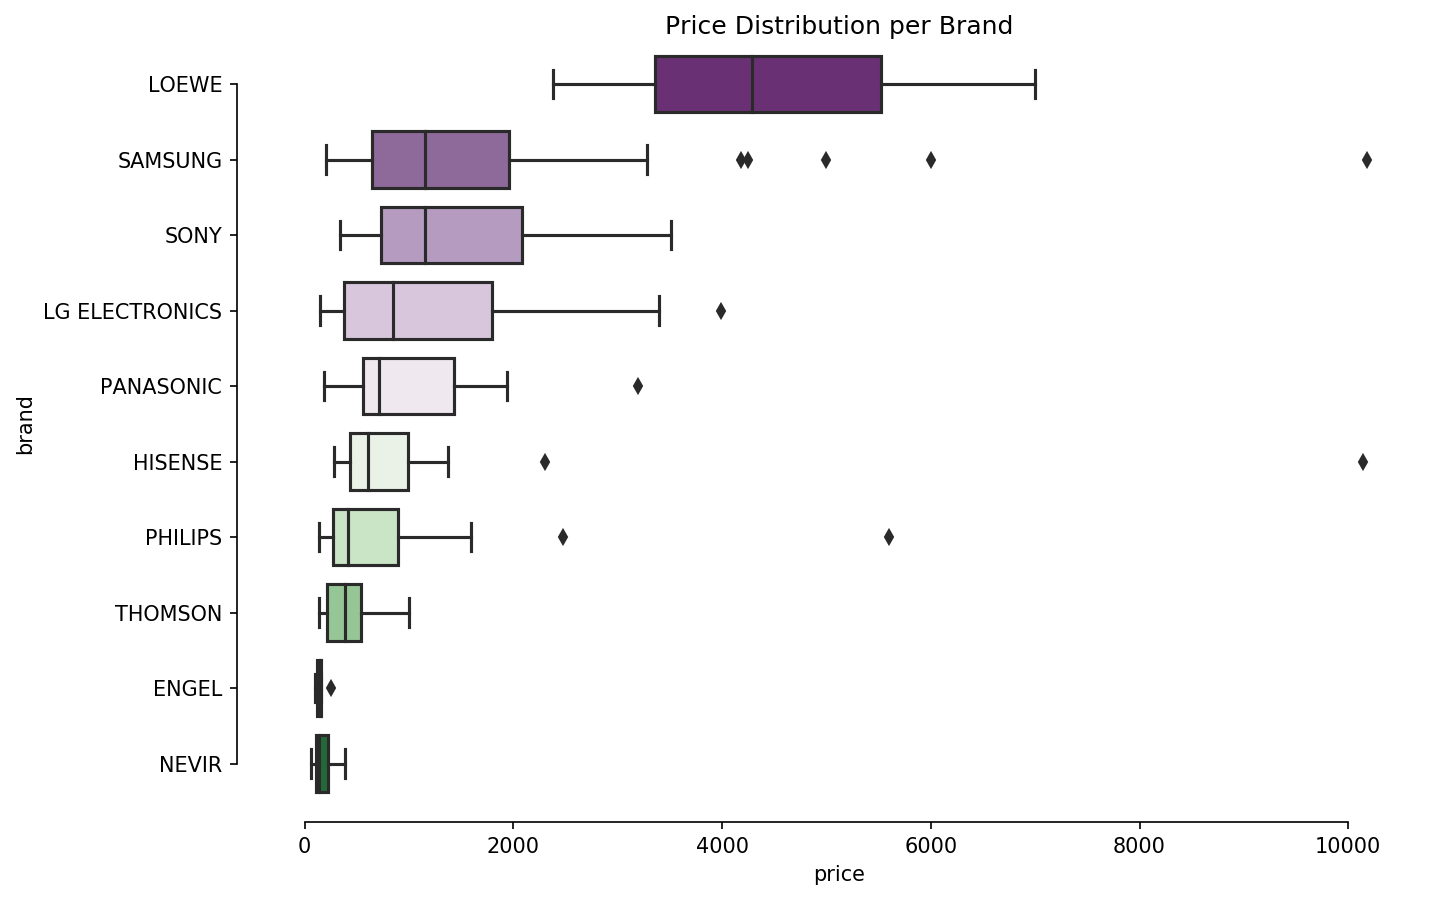

Visualization saved to ./plots/price_distribution_brand.png


In [60]:
#query = total_products.producto == 'Instantáneas y retro'
query = total_products.producto == 'Televisores'

viz_data(dat.replace('info', 'info_'+now.strftime("%Y%m%d")), viz, query, 1500, 1000)

In [18]:
# Recuperamos el archivo guardado
catalogue =  pd.read_csv('./data/productinfo_20190410.csv', dtype={'ean': str, 'id': str}, index_col=0)

In [19]:
catalogue

,ean,id,category,subcategory,producto,subproducto,brand,name,price,quantity,date,iva_aplicado,stock_status,coste_envio
0,8710103738350,1293941,Belleza y salud,Afeitado y depilación,Afeitadoras faciales,NaN,PHILIPS,"Afeitadora - Philips S 5110/06 Cabezales Flex,...",57.99,NaN,2019-04-10,21.0,OutOfStock,1.99
1,8710103764588,1317305,Belleza y salud,Afeitado y depilación,Afeitadoras faciales,NaN,PHILIPS,"Afeitadora - Philips Shaver S1510/04, Recargab...",41.99,NaN,2019-04-10,21.0,InStock,1.99
2,8710103819219,1360370,Belleza y salud,Afeitado y depilación,Afeitadoras faciales,NaN,PHILIPS,"Afeitadora - Philips S5550/06, Cuchillas Multi...",89.90,NaN,2019-04-10,21.0,OutOfStock,1.99
3,8710103764489,1317303,Belleza y salud,Afeitado y depilación,Afeitadoras faciales,NaN,PHILIPS,"Afeitadora - Philips S3510/06, sistema Comfort...",58.99,NaN,2019-04-10,21.0,InStock,1.99
4,4210201147022,1294131,Belleza y salud,Afeitado y depilación,Afeitadoras faciales,NaN,BRAUN,"Afeitadora - Braun 5030s Series 5 + EN10, Reco...",87.99,NaN,2019-04-10,21.0,InStock,1.99
5,8710103738121,1293945,Belleza y salud,Afeitado y depilación,Afeitadoras faciales,NaN,PHILIPS,Afeitadora - Philips S 5420/06 Sistema de cuch...,76.99,NaN,2019-04-10,21.0,InStock,1.99
6,8710103686934,1252110,Belleza y salud,Afeitado y depilación,Afeitadoras faciales,NaN,PHILIPS,"Afeitadora - Philips S9031/12 V-Track, Autonom...",165.00,NaN,2019-04-10,21.0,InStock,1.99
7,8710103609803,1187436,Belleza y salud,Afeitado y depilación,Afeitadoras faciales,NaN,PHILIPS,"Afeitadora - Philips AT750/26, Recargable, Cab...",55.99,NaN,2019-04-10,21.0,InStock,1.99
8,8710103800958,1385320,Belleza y salud,Afeitado y depilación,Afeitadoras faciales,NaN,PHILIPS,"Afeitadora - Philips S7522/50, Anillos SkinGli...",149.00,NaN,2019-04-10,21.0,InStock,1.99
9,8710103764458,1317304,Belleza y salud,Afeitado y depilación,Afeitadoras faciales,NaN,PHILIPS,"Afeitadora - Philips S3110/06, sistema Comfort...",49.99,NaN,2019-04-10,21.0,InStock,1.99
